# <center><u><font color='red'>Projet 6 : Classifiez automatiquement des biens de consommation</font></u><br> <br><font color='red'>Partie 3 : Classification par la combinaison de la description et de l'image </font></center> 

# <font color='green'>Setting up the work environment</font>

## <font color='blue'>Library</font>

In [1]:
# import packages
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras import layers
from keras import Sequential, optimizers
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import keras
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial import distance
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
import imutils
import PIL
import cv2
import collections
from scipy.stats import variation
from scipy import stats
from scipy.stats.stats import pearsonr
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import nltk
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import missingno as msno
import pickle
#import mss
import os
from os import listdir
import pandas as pd
import numpy as np
import re
import math
from termcolor import colored
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.options.display.width = 0

%matplotlib inline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## <font color='blue'>Fonction</font>

In [2]:
def clustering(algo, data, true_category, label_true_category, algo_name, file_name=None):

    print(colored("Exécution \n ", 'red'))
    model = algo.fit(data)

    if file_name is None:
        pass
    else :
        # save the model to disk
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    label_model = model.labels_

    lines = model.labels_.shape[0]
    print(colored(
        "Nombre de lignes pris en compte pour le clustering {} \n \n".format(lines), 'blue'))


    labels = pd.DataFrame(label_model, columns=['algo_cluster'])

    mylist = list(set(label_model))
    nb_cluster = len(mylist)

    print(colored("Qualité du Clustering \n \n ", 'red'))

    # mean Silhouette Coefficient of all samples
    """    label = model.labels_
    unique, counts = np.unique(label, return_counts=True)
    print(unique)"""

    silhouette = silhouette_score(X=data, labels=model.labels_)
    print(colored('Le coefficient de silhouette moyen est de {} pour la méthode {}.\n \n '.format(
        silhouette, algo_name), 'blue'))

    tot_data_label = pd.concat([true_category, label_true_category, labels], axis=1, names=[
        'category', 'label_category', 'algo_cluster'])
    tot_data_label.reset_index(drop=True)

    # Indice de Rand ajusté.
    ARI = adjusted_rand_score(
        tot_data_label['label_category'], tot_data_label['algo_cluster'])
    print(colored('Le score ARI est de {} pour la méthode {}. \n \n'.format(
        ARI, algo_name), 'blue'))

    print(colored("Visualisation \n \n ", 'red'))

    tsne = TSNE(n_components=2, init="pca")
    X_trans = tsne.fit_transform(data)

    plt.figure(figsize=(10, 10))
    plt.title(
        "TSNE selon les clusters via {}.\n" .format(algo_name), fontsize=30)
    sns.scatterplot(
        X_trans[:, 0],
        X_trans[:, 1],
        hue=model.labels_,
        legend="brief",
        palette=sns.color_palette("husl", nb_cluster),

    )
    sns.set_context("paper", font_scale=1)
    plt.xlabel("tsne1")
    plt.xlabel("tsne2")
    plt.show()

    print("ARI : ", adjusted_rand_score(tot_data_label['label_category'], tot_data_label['algo_cluster']))
    print('\n \n')


    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 40

    values = tot_data_label['algo_cluster'].value_counts()
    labels = tot_data_label['algo_cluster'].value_counts().index

    #color = ['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple', 'yellow', 'red', 'brown', 'violet']
    #colors = color[:nb_cluster]

    # Plot
    from matplotlib import cm
    cs = cm.Set2(np.arange(nb_cluster))

    plt.figure(figsize=(10, 10))
    plt.pie(values, labels=labels, colors=cs,
            autopct='%.2f%%', shadow=True, textprops={'fontsize': 24})

    plt.title(
        "Répartition des produits entre les différentes catégories déterminées par l'algorithme {}" .format(algo_name), fontsize=30)

    plt.axis('equal')
    plt.tight_layout()

    plt.show()

    return silhouette, ARI, tot_data_label

In [3]:
def classification(best_param, X_train, y_train, X_test, y_test, algo_name, file_name=None):
    print(colored("Exécution \n ", 'red'))
    model = best_param.fit(X_train, y_train)
    
    if file_name is None:
        pass
    else :
        # save the model to disk
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    prediction = best_param.predict(X_test)
    resume_class = pd.DataFrame(
        {'cat_reel': y_test, 'cat_predit': prediction}).reset_index()

    print(colored("Qualité de la classification \n \n ", 'red'))
    accuracy = accuracy_score(y_test, prediction)
    print(colored('L\'accuracy score est de {} pour la méthode {}.\n \n '.format(
        accuracy, algo_name), 'blue'))

    precision = precision_score(y_test, prediction, average='weighted')
    print(colored('Le score de précision est de {} pour la méthode {}.\n \n '.format(
        precision, algo_name), 'blue'))

    recall = recall_score(y_test, prediction, average='weighted')
    print(colored('Le score recall est de {} pour la méthode {}.\n \n '.format(
        recall, algo_name), 'blue'))

    f1 = f1_score(y_test, prediction, average='weighted')
    print(colored('Le score f1 est de {} pour la méthode {}.\n \n '.format(
        f1, algo_name), 'blue'))

    le = preprocessing.LabelEncoder()
    resume_class['label_cat_reel'] = le.fit_transform(
        np.array(resume_class['cat_reel']))
    resume_class['label_cat_predit'] = le.transform(
        np.array(resume_class['cat_predit']))

    print(colored("Visualisation \n \n ", 'red'))
    plt.figure(figsize=(10, 10))
    plt.title('Répartition des catégories après classification par la méthode {}.\n \n '.format(
        algo_name), fontsize=18, fontweight="bold")
    sns.distplot(resume_class['label_cat_reel'], bins=20, rug=True)
    sns.distplot(resume_class['label_cat_predit'], bins=20, rug=True)
    plt.xlabel("Catégories")
    plt.legend(['reel', 'prediction'])

    from matplotlib import cm
    fig = plt.figure(figsize=(30, 15))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    nb_label_real = resume_class['cat_reel'].nunique()
    cs_nb_label_real = cm.Set2(np.arange(nb_label_real))
    nb_label_predit = resume_class['cat_predit'].nunique()
    cs_nb_label_predit = cm.Set2(np.arange(nb_label_predit))

    ax1 = resume_class.groupby('cat_reel').count().plot(kind='pie',
                                                        y='label_cat_reel',
                                                        ax=ax1,
                                                        legend=False,
                                                        shadow=True,
                                                        startangle=0,
                                                        autopct='%1.1f%%',
                                                        textprops={
                                                            'fontsize': 26},
                                                        colors=cs_nb_label_real)
    ax1.axis('equal')
    ax1.set_xlabel("classes réelles", fontsize=22)
    ax1.set_ylabel(" ")

    ax2 = resume_class.groupby('cat_predit').count().plot(kind='pie',
                                                          y='label_cat_predit',
                                                          ax=ax2,
                                                          legend=False,
                                                          shadow=True,
                                                          startangle=0,
                                                          autopct='%1.1f%%',
                                                          textprops={
                                                              'fontsize': 26},
                                                          colors=cs_nb_label_predit)
    ax2.axis('equal')
    ax2.set_xlabel("classes prédites par {}" .format(
        algo_name), fontsize=22)
    ax2.set_ylabel(" ")

    plt.suptitle('Répartition des produits (test data) entre les différentes catégories déterminées',
                 fontsize=30)

    plt.subplots_adjust(wspace=1.5)

    plt.show()

    cf_matrix = confusion_matrix(
        resume_class["cat_reel"], resume_class["cat_predit"], normalize='true')
    plt.figure(figsize=(18, 12))
    plt.title('Matrice de confusion', size=20, weight='bold')
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cf_matrix, annot=True,
                fmt='.2%', cmap='BuPu',
                annot_kws={"size": 15, 'weight': 'bold'})
    plt.ylabel("Vraie catégorie", weight='bold', size=20)
    plt.xlabel('Prediction', weight='bold', size=17)
    plt.show()

    return accuracy, precision, recall, f1, resume_class

# <font color='green'>Association des Descriptions et des images</font>

## <font color='blue'>Préparation BOW Description (tf-idf du notebook 01) </font>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\Drive/Data_projet_OC
!ls

data = pd.read_csv(
    '/content/drive/MyDrive/df_tfidfvect_total.csv')

Mounted at /content/drive
/content/drive/MyDrive/Data_projet_OC
 cheval.png			 Flipkart	  X_train_nt3.csv
 df_tfidfvect.csv		'Testing Set'	  y_test_nt3.csv
 df_tfidfvect_total.csv		'Training Set'	  y_train_nt3.csv
 df_untokenize_description.csv	 X_test_nt3.csv


In [5]:
data

,image,category,abstract,accessory,actual,adapter,additional,adorable,affordable,aluminium,analog,antique,apple,apply,area,aroma,around,assured,attractive,audio,authentication,available,baby,back,base,bath,battery,beautiful,beautifully,beauty,bedroom,bedsheet,best,black,blanket,bleach,blue,body,bottle,boy,...,touch,towel,traditional,trait,tube,tumble,type,unique,used,using,vary,video,vinyl,vitamin,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,water,waterproof,wear,wedding,weight,well,white,wide,width,wireless,without,woman,wood,wooden,work,world,year,yellow
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home_furnishing,0.202646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066794,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.045269,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.030333,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.066794,0.000000,0.000000
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby_care,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594827,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.165989,0.000000,0.0,0.085949,...,0.0,0.590547,0.0,0.0,0.0,0.0,0.054075,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.099876,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.072941,0.0,0.0,0.077797,0.0,0.0,0.0,0.000000,0.000000,0.202861
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby_care,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115545,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.055818,0.000000,0.000000,0.0,0.050087,...,0.0,0.630927,0.0,0.0,0.0,0.0,0.031512,0.0,0.000000,0.0,0.117295,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000,0.136487,0.000000,0.0,0.042381,0.0,0.0,0.000000,0.044419,0.0,0.000000,0.0,0.042507,0.0,0.0,0.045336,0.0,0.0,0.0,0.000000,0.053506,0.000000
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home_furnishing,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.439344,0.000000,0.0,0.0,0.059776,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.033746,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000,0.048721,0.062329,0.0,0.000000,0.0,0.0,0.139163,0.000000,0.0,0.000000,0.0,0.136561,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home_furnishing,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.304800,0.000000,0.0,0.0,0.049764,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.028094,0.0,0.051507,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0433,0.000000,0.051890,0.0,0.000000,0.0,0.0,0.000000,0.039601,0.0,0.140024,0.0,0.113689,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby_care,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.289998,0.096666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.173842,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.711448,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000

In [6]:
bow = data.copy()
del bow['image']
del bow['category']
bow

,abstract,accessory,actual,adapter,additional,adorable,affordable,aluminium,analog,antique,apple,apply,area,aroma,around,assured,attractive,audio,authentication,available,baby,back,base,bath,battery,beautiful,beautifully,beauty,bedroom,bedsheet,best,black,blanket,bleach,blue,body,bottle,boy,brand,brass,...,touch,towel,traditional,trait,tube,tumble,type,unique,used,using,vary,video,vinyl,vitamin,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,water,waterproof,wear,wedding,weight,well,white,wide,width,wireless,without,woman,wood,wooden,work,world,year,yellow
0,0.202646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066794,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.045269,0.0,0.000000,0.031977,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.030333,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.066794,0.000000,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594827,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.165989,0.000000,0.0,0.085949,0.057006,0.0,...,0.0,0.590547,0.0,0.0,0.0,0.0,0.054075,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.099876,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.072941,0.0,0.0,0.077797,0.0,0.0,0.0,0.000000,0.000000,0.202861
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115545,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.055818,0.000000,0.000000,0.0,0.050087,0.066441,0.0,...,0.0,0.630927,0.0,0.0,0.0,0.0,0.031512,0.0,0.000000,0.0,0.117295,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000,0.136487,0.000000,0.0,0.042381,0.0,0.0,0.000000,0.044419,0.0,0.000000,0.0,0.042507,0.0,0.0,0.045336,0.0,0.0,0.0,0.000000,0.053506,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.439344,0.000000,0.0,0.0,0.059776,0.000000,0.000000,0.0,0.000000,0.035576,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.033746,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000,0.048721,0.062329,0.0,0.000000,0.0,0.0,0.139163,0.000000,0.0,0.000000,0.0,0.136561,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.304800,0.000000,0.0,0.0,0.049764,0.000000,0.000000,0.0,0.000000,0.029617,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.028094,0.0,0.051507,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0433,0.000000,0.051890,0.0,0.000000,0.0,0.0,0.000000,0.039601,0.0,0.140024,0.0,0.113689,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.289998,0.096666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.173842,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.711448,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1046,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.519530,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.066307,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0

In [7]:
print("Dimensions dataset avant réduction PCA : ", bow.shape)
pca = PCA(n_components=0.95)
features_description_extraction_pca = pd.DataFrame(pca.fit_transform(bow))
print("Dimensions dataset après réduction PCA : ", features_description_extraction_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 445)
Dimensions dataset après réduction PCA :  (1050, 195)


In [8]:
df_bow = pd.concat([data['image'], data['category'], features_description_extraction_pca], axis=1)

In [9]:
df_bow.columns = ['image', 'product_category'] + ['Feature BoW {}'.format(i) for i in range(195)]
df_bow.head()

,image,product_category,Feature BoW 0,Feature BoW 1,Feature BoW 2,Feature BoW 3,Feature BoW 4,Feature BoW 5,Feature BoW 6,Feature BoW 7,Feature BoW 8,Feature BoW 9,Feature BoW 10,Feature BoW 11,Feature BoW 12,Feature BoW 13,Feature BoW 14,Feature BoW 15,Feature BoW 16,Feature BoW 17,Feature BoW 18,Feature BoW 19,Feature BoW 20,Feature BoW 21,Feature BoW 22,Feature BoW 23,Feature BoW 24,Feature BoW 25,Feature BoW 26,Feature BoW 27,Feature BoW 28,Feature BoW 29,Feature BoW 30,Feature BoW 31,Feature BoW 32,Feature BoW 33,Feature BoW 34,Feature BoW 35,Feature BoW 36,Feature BoW 37,...,Feature BoW 155,Feature BoW 156,Feature BoW 157,Feature BoW 158,Feature BoW 159,Feature BoW 160,Feature BoW 161,Feature BoW 162,Feature BoW 163,Feature BoW 164,Feature BoW 165,Feature BoW 166,Feature BoW 167,Feature BoW 168,Feature BoW 169,Feature BoW 170,Feature BoW 171,Feature BoW 172,Feature BoW 173,Feature BoW 174,Feature BoW 175,Feature BoW 176,Feature BoW 177,Feature BoW 178,Feature BoW 179,Feature BoW 180,Feature BoW 181,Feature BoW 182,Feature BoW 183,Feature BoW 184,Feature BoW 185,Feature BoW 186,Feature BoW 187,Feature BoW 188,Feature BoW 189,Feature BoW 190,Feature BoW 191,Feature BoW 192,Feature BoW 193,Feature BoW 194
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home_furnishing,-0.290536,-0.055178,-0.021944,-0.137678,-0.118319,-0.062778,-0.162851,-0.112000,0.037331,-0.075414,-0.105502,-0.052427,-0.222626,-0.186139,0.290747,-0.181561,0.230281,-0.155753,0.247371,0.211355,-0.016778,0.251533,-0.027388,0.007481,0.031464,-0.047316,-0.050480,-0.039695,0.001627,-0.009869,-0.054950,0.019936,-0.119538,0.061798,-0.047739,-0.058034,-0.003979,0.057130,...,-0.013324,0.011040,-0.026769,-0.005678,0.013365,-0.034153,0.033871,0.018409,0.024850,-0.036647,0.001969,0.000522,0.012665,-0.015348,-0.016940,0.048840,-0.034824,0.015900,0.010637,-0.003162,0.017288,-0.014950,-0.044971,0.015367,0.015155,0.005114,-0.055468,0.008781,0.004223,0.019680,-0.009510,-0.014275,0.018649,-0.034456,-0.032513,0.011098,0.031725,-0.006477,-0.012184,-0.047735
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby_care,-0.298032,-0.042844,-0.127226,0.014708,-0.127724,-0.252887,0.024550,0.656891,0.134293,-0.131554,0.017316,-0.082842,0.009625,0.061029,0.128097,0.040999,0.042708,-0.060368,-0.024572,-0.057405,0.000935,0.014323,0.026763,-0.072986,-0.120268,0.089318,-0.005001,-0.056429,0.048311,0.007199,0.067649,0.015252,0.013346,-0.027866,0.007981,-0.098753,0.004245,-0.078745,...,-0.012065,0.008385,-0.021012,-0.027299,-0.001258,0.038680,-0.005523,0.039091,0.014586,0.023010,-0.004799,0.014407,0.004623,-0.000899,-0.021111,-0.005476,0.004060,0.003100,-0.037783,-0.016341,-0.010814,0.008608,-0.030737,0.018545,0.008178,0.003473,-0.014830,0.011833,-0.007385,-0.003387,0.013069,0.004634,-0.029311,-0.010903,0.033048,-0.014639,0.001001,0.025371,0.025406,-0.015025
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby_care,-0.284868,-0.053634,-0.095143,-0.006220,-0.105319,-0.200180,0.053585,0.584656,0.110719,-0.076570,0.059080,-0.054684,0.032113,0.026646,0.053706,0.015579,-0.002188,0.004596,0.004247,-0.033869,0.007037,0.000494,0.010345,0.005875,-0.043104,-0.031519,0.032492,0.031808,0.064194,0.010337,0.054228,0.009903,0.022773,0.047500,-0.063791,-0.030304,-0.029930,-0.041551,...,0.043924,0.010073,-0.077806,-0.069296,-0.010257,-0.035485,0.010851,0.014526,0.033361,-0.007862,0.057100,0.003790,-0.025510,0.051103,-0.013761,-0.099970,-0.010190,-0.048796,-0.031689,0.027387,0.017546,-0.058916,-0.049031,-0.026991,-0.023626,-0.058822,0.018488,-0.018376,-0.018347,0.016525,0.038203,-0.013062,-0.062417,0.004090,0.025907,-0.008888,0.014657,0.018475,0.001457,-0.029138
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home_furnishing,-0.304484,-0.048035,-0.065740,-0.032090,-0.147239,-0.087522,-0.111245,0.003345,0.001330,-0.136440,-0.049253,-0.148497,0.295540,0.039194,-0.104970,-0.041376,0.006440,0.043329,0.021254,0.021261,-0.079544,0.012018,-0.032911,-0.025887,-0.115802,-0.016120,0.089018,-0.030133,0.086390,0.088696,0.081227,0.368616,0.002873,0.320245,0.

In [10]:
"""path = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Flipkart/Images/"""

path = "/content/drive/MyDrive/Data_projet_OC/Flipkart/Images/"


list_name_pictures = [file for file in listdir(path)]
print(len(list_name_pictures))

1050


In [11]:
img_name = []

for j in os.listdir(path):
    img_name.append(j)

df_image_order = pd.DataFrame(img_name)
df_image_order.columns = ['image']

In [12]:
df_bow_ordered = pd.merge(
    df_image_order, df_bow, left_on='image', right_on='image')

In [13]:
df_bow_ordered.head()

,image,product_category,Feature BoW 0,Feature BoW 1,Feature BoW 2,Feature BoW 3,Feature BoW 4,Feature BoW 5,Feature BoW 6,Feature BoW 7,Feature BoW 8,Feature BoW 9,Feature BoW 10,Feature BoW 11,Feature BoW 12,Feature BoW 13,Feature BoW 14,Feature BoW 15,Feature BoW 16,Feature BoW 17,Feature BoW 18,Feature BoW 19,Feature BoW 20,Feature BoW 21,Feature BoW 22,Feature BoW 23,Feature BoW 24,Feature BoW 25,Feature BoW 26,Feature BoW 27,Feature BoW 28,Feature BoW 29,Feature BoW 30,Feature BoW 31,Feature BoW 32,Feature BoW 33,Feature BoW 34,Feature BoW 35,Feature BoW 36,Feature BoW 37,...,Feature BoW 155,Feature BoW 156,Feature BoW 157,Feature BoW 158,Feature BoW 159,Feature BoW 160,Feature BoW 161,Feature BoW 162,Feature BoW 163,Feature BoW 164,Feature BoW 165,Feature BoW 166,Feature BoW 167,Feature BoW 168,Feature BoW 169,Feature BoW 170,Feature BoW 171,Feature BoW 172,Feature BoW 173,Feature BoW 174,Feature BoW 175,Feature BoW 176,Feature BoW 177,Feature BoW 178,Feature BoW 179,Feature BoW 180,Feature BoW 181,Feature BoW 182,Feature BoW 183,Feature BoW 184,Feature BoW 185,Feature BoW 186,Feature BoW 187,Feature BoW 188,Feature BoW 189,Feature BoW 190,Feature BoW 191,Feature BoW 192,Feature BoW 193,Feature BoW 194
0,f01140c02fd09e5c56312a64fa8db3da.jpg,kitchen_and_dining,-0.339980,-0.025793,0.005679,-0.140263,0.012972,0.074997,-0.104951,0.000566,0.101451,-0.080878,-0.154112,0.118541,-0.035400,-0.092311,-0.043119,0.081469,-0.096427,-0.140523,-0.106446,-0.152579,0.009416,0.012685,-0.093233,-0.049140,0.259795,-0.079259,0.029009,-0.172519,0.144775,-0.027043,-0.077028,-0.021914,0.001206,0.040653,-0.012717,-0.095813,-0.021391,-0.033565,...,0.095732,0.017546,-0.070744,0.059935,0.064342,0.027512,-0.031221,-0.069198,-0.062530,-0.076910,-0.104009,-0.038495,0.011102,0.032568,-0.066736,-0.011271,0.034804,0.037298,-0.005905,0.029253,0.026852,-0.114108,-0.040001,-0.004324,0.120938,-0.135076,-0.036556,0.031446,0.061222,-0.022385,0.080798,0.005300,0.030647,-0.036388,-0.068149,-0.055231,0.011697,-0.034799,0.026741,-0.027905
1,b4d35b6536b623c83b293eb3a1c02bba.jpg,computers,-0.256665,-0.025599,0.028749,-0.120884,-0.115659,0.143292,0.068201,0.008772,-0.038594,-0.048462,0.005605,-0.012013,-0.123944,0.162471,-0.085930,0.183013,0.059151,-0.037166,0.001953,0.028697,0.017873,-0.007790,-0.020623,-0.009332,0.012282,0.021142,0.000842,-0.013068,-0.082912,0.017034,-0.033047,-0.007560,0.075982,0.054751,-0.042843,0.008376,0.000181,0.057838,...,-0.099108,0.082239,0.000659,0.048285,-0.047914,0.020940,-0.033127,-0.032892,-0.034832,0.011743,0.032163,0.012170,-0.004631,0.053849,0.026787,0.010317,0.001672,-0.034853,-0.007345,-0.069114,0.046033,-0.059599,-0.064930,0.013824,-0.041211,0.029771,0.077596,0.065240,0.020213,0.048499,0.029092,-0.019601,0.045746,-0.008485,0.025077,0.025079,-0.027544,-0.003399,-0.052682,-0.022838
2,69446af66066146718cd569f87e99fff.jpg,kitchen_and_dining,-0.328396,-0.071964,0.067223,-0.199463,0.246863,-0.017311,-0.036504,-0.033853,0.190859,0.108532,-0.246304,0.004533,0.138933,0.042518,0.145234,0.126947,0.074518,0.082451,-0.018949,-0.158561,0.040966,-0.038422,-0.035194,-0.027334,0.002179,-0.015555,0.035402,-0.006429,-0.051570,0.061280,-0.083305,-0.039239,0.068163,-0.036956,-0.091305,0.029104,-0.161609,-0.011543,...,-0.023947,-0.003927,-0.006266,0.004277,-0.018738,-0.001200,0.013180,0.041891,0.012209,-0.070844,0.001836,-0.035364,0.034894,-0.001557,0.091149,-0.022565,-0.030753,0.051837,-0.004229,0.051836,-0.037914,0.013474,-0.041796,-0.056729,0.008597,0.031858,-0.011189,0.007007,0.018540,-0.018677,-0.024777,-0.039831,-0.010289,-0.010852,0.037296,-0.043087,-0.049698,0.029121,0.005290,0.010410
3,6329ddb46087cb8c09ced95471dd9643.jpg,computers,-0.260871,-0.033179,0.004478,-0.103618,-0.087183,0.037247,-0.026402,-0.017065,0.005310,-0.055436,-0.020090,-0.033572,-0.109571,0.050707,-0.034131,-0.013216,-0.058408,-0.024945,-0.023924,-0.067022,-0.032462,-0.071265,-0.016019,-0.000135,-0.029666,0.060762,-0.008098,-0.043137,-0.096720,0.069329,-0.194841,0.023976,0.0

## <font color='blue'>Préparation Feature Image (CNN donne de meilleurs résultats que ORB/SIFT : Notebook 2)</font>

In [14]:
# Path du dossier.
folder = "/content/drive/MyDrive/Data_projet_OC/Flipkart/Images/"
 
x_scratch = []
name_img = []

# Boucle pour charger les images.
for img in os.listdir(folder):
    
    # Path.
    path = folder + '/' + img
    
    name_img.append(img)

    # Chargement des images et sizing à 224*224 pixels.
    img_resize = load_img(path, target_size=(224, 224))
    img = img_to_array(img_resize)

    # Preprocessing adapté à l'utilisation de VGG16.
    image = np.expand_dims(img, axis=0)
    image = preprocess_input(image)

    x_scratch.append(image)

x = np.vstack(x_scratch)

In [15]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected (couches hautes).
model_features_extraction = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [16]:
features = model_features_extraction.predict(x, batch_size=5, verbose=1)
features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))

210/210 [==============================] - 272s 1s/step


In [17]:
print("Dimensions dataset avant réduction PCA : ", features_flatten.shape)
pca = PCA(n_components=0.95)
df_features_image_extraction_pca = pd.DataFrame(pca.fit_transform(features_flatten))
print("Dimensions dataset après réduction PCA : ", df_features_image_extraction_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 745)


In [18]:
df_features_image_extraction_pca.columns = ['Principal Component {}'.format(i) for i in range(745)]

In [19]:
df_order_image = pd.DataFrame(name_img)
df_order_image.columns = ['image']

In [20]:
df_features_extraction_pca = pd.concat([df_order_image, df_features_image_extraction_pca], axis=1)
df_features_extraction_pca

,image,Principal Component 0,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Principal Component 11,Principal Component 12,Principal Component 13,Principal Component 14,Principal Component 15,Principal Component 16,Principal Component 17,Principal Component 18,Principal Component 19,Principal Component 20,Principal Component 21,Principal Component 22,Principal Component 23,Principal Component 24,Principal Component 25,Principal Component 26,Principal Component 27,Principal Component 28,Principal Component 29,Principal Component 30,Principal Component 31,Principal Component 32,Principal Component 33,Principal Component 34,Principal Component 35,Principal Component 36,Principal Component 37,Principal Component 38,...,Principal Component 705,Principal Component 706,Principal Component 707,Principal Component 708,Principal Component 709,Principal Component 710,Principal Component 711,Principal Component 712,Principal Component 713,Principal Component 714,Principal Component 715,Principal Component 716,Principal Component 717,Principal Component 718,Principal Component 719,Principal Component 720,Principal Component 721,Principal Component 722,Principal Component 723,Principal Component 724,Principal Component 725,Principal Component 726,Principal Component 727,Principal Component 728,Principal Component 729,Principal Component 730,Principal Component 731,Principal Component 732,Principal Component 733,Principal Component 734,Principal Component 735,Principal Component 736,Principal Component 737,Principal Component 738,Principal Component 739,Principal Component 740,Principal Component 741,Principal Component 742,Principal Component 743,Principal Component 744
0,f01140c02fd09e5c56312a64fa8db3da.jpg,47.501534,78.069267,278.580475,88.402855,226.873260,-243.421875,114.061913,135.315201,-130.671295,53.022282,221.304871,170.229965,86.647720,-57.861454,67.801323,-46.379032,51.597363,-66.632629,-81.232025,-14.184587,-80.158562,38.451614,-47.694305,40.459244,-237.880112,19.879066,105.964455,-36.024342,116.582321,-33.430031,74.378456,-8.434104,-33.014267,31.148991,37.159424,-38.879799,-61.085236,22.913485,40.702412,...,6.148522,15.640061,14.466612,5.936429,23.913778,-24.455269,0.139871,32.393299,-16.744816,14.453374,24.709017,30.439554,23.608690,15.866031,12.954233,25.530910,-11.406713,5.425672,2.792246,-30.092266,16.162081,-8.831730,35.533306,-3.042549,2.211890,3.587127,11.021719,-22.280632,3.457598,5.157306,2.124581,19.623446,-33.887367,-34.642109,-43.175449,2.065281,18.008556,-6.457664,-29.500772,-16.467255
1,b4d35b6536b623c83b293eb3a1c02bba.jpg,-158.536484,-161.657761,-24.215393,-68.864708,91.076775,-169.021210,138.799728,77.724632,-85.364906,171.930923,-119.434448,-59.260036,18.465010,29.254267,-34.707035,-101.471054,-23.321651,50.797676,114.054825,63.991940,48.005783,37.842602,132.357025,52.709019,1.850024,-99.622978,2.222403,17.938971,105.408173,-31.249435,41.433334,17.559269,44.512978,-52.794582,56.061783,128.068787,-44.318897,-49.648487,-57.139378,...,11.164635,-1.141047,22.735876,-11.940201,18.629704,0.376101,-21.022385,-54.023327,15.452373,36.954727,24.481157,28.885323,-19.505980,-56.684998,-19.985683,-24.673113,-44.748829,2.110186,38.367439,16.240841,8.756455,-19.059517,-9.810949,16.724016,-7.053120,3.373698,6.055670,-9.972054,44.336063,-9.181163,-38.705410,3.521884,-6.268561,13.212087,-5.783704,-31.471960,7.600857,4.468281,-6.836858,11.715006
2,69446af66066146718cd569f87e99fff.jpg,-190.977737,370.004974,486.494110,723.511597,-87.442993,125.962143,-84.915031,-88.687935,-3.834314,148.435623,-22.819183,77.707153,-14.531021,99.583191,-63.553486,-78.255829,9.039486,-40.078358,-55.111965,-130.850372,-22.140041,-120.609711,-124.374046,40.745930,-8.423914,-3.966296,111.781029,-38.953682,109.295593,140.116409,-94.090439,62.833145,-68.818199,41.079891,51.563652,-71.1

## <font color='blue'>Association Bow Description et Features Images</font>

In [21]:
df_desc_img = pd.merge(df_bow_ordered, df_features_extraction_pca, 
                       left_on='image', right_on='image')
df_desc_img.head()

,image,product_category,Feature BoW 0,Feature BoW 1,Feature BoW 2,Feature BoW 3,Feature BoW 4,Feature BoW 5,Feature BoW 6,Feature BoW 7,Feature BoW 8,Feature BoW 9,Feature BoW 10,Feature BoW 11,Feature BoW 12,Feature BoW 13,Feature BoW 14,Feature BoW 15,Feature BoW 16,Feature BoW 17,Feature BoW 18,Feature BoW 19,Feature BoW 20,Feature BoW 21,Feature BoW 22,Feature BoW 23,Feature BoW 24,Feature BoW 25,Feature BoW 26,Feature BoW 27,Feature BoW 28,Feature BoW 29,Feature BoW 30,Feature BoW 31,Feature BoW 32,Feature BoW 33,Feature BoW 34,Feature BoW 35,Feature BoW 36,Feature BoW 37,...,Principal Component 705,Principal Component 706,Principal Component 707,Principal Component 708,Principal Component 709,Principal Component 710,Principal Component 711,Principal Component 712,Principal Component 713,Principal Component 714,Principal Component 715,Principal Component 716,Principal Component 717,Principal Component 718,Principal Component 719,Principal Component 720,Principal Component 721,Principal Component 722,Principal Component 723,Principal Component 724,Principal Component 725,Principal Component 726,Principal Component 727,Principal Component 728,Principal Component 729,Principal Component 730,Principal Component 731,Principal Component 732,Principal Component 733,Principal Component 734,Principal Component 735,Principal Component 736,Principal Component 737,Principal Component 738,Principal Component 739,Principal Component 740,Principal Component 741,Principal Component 742,Principal Component 743,Principal Component 744
0,f01140c02fd09e5c56312a64fa8db3da.jpg,kitchen_and_dining,-0.339980,-0.025793,0.005679,-0.140263,0.012972,0.074997,-0.104951,0.000566,0.101451,-0.080878,-0.154112,0.118541,-0.035400,-0.092311,-0.043119,0.081469,-0.096427,-0.140523,-0.106446,-0.152579,0.009416,0.012685,-0.093233,-0.049140,0.259795,-0.079259,0.029009,-0.172519,0.144775,-0.027043,-0.077028,-0.021914,0.001206,0.040653,-0.012717,-0.095813,-0.021391,-0.033565,...,6.148522,15.640061,14.466612,5.936429,23.913778,-24.455269,0.139871,32.393299,-16.744816,14.453374,24.709017,30.439554,23.608690,15.866031,12.954233,25.530910,-11.406713,5.425672,2.792246,-30.092266,16.162081,-8.831730,35.533306,-3.042549,2.211890,3.587127,11.021719,-22.280632,3.457598,5.157306,2.124581,19.623446,-33.887367,-34.642109,-43.175449,2.065281,18.008556,-6.457664,-29.500772,-16.467255
1,b4d35b6536b623c83b293eb3a1c02bba.jpg,computers,-0.256665,-0.025599,0.028749,-0.120884,-0.115659,0.143292,0.068201,0.008772,-0.038594,-0.048462,0.005605,-0.012013,-0.123944,0.162471,-0.085930,0.183013,0.059151,-0.037166,0.001953,0.028697,0.017873,-0.007790,-0.020623,-0.009332,0.012282,0.021142,0.000842,-0.013068,-0.082912,0.017034,-0.033047,-0.007560,0.075982,0.054751,-0.042843,0.008376,0.000181,0.057838,...,11.164635,-1.141047,22.735876,-11.940201,18.629704,0.376101,-21.022385,-54.023327,15.452373,36.954727,24.481157,28.885323,-19.505980,-56.684998,-19.985683,-24.673113,-44.748829,2.110186,38.367439,16.240841,8.756455,-19.059517,-9.810949,16.724016,-7.053120,3.373698,6.055670,-9.972054,44.336063,-9.181163,-38.705410,3.521884,-6.268561,13.212087,-5.783704,-31.471960,7.600857,4.468281,-6.836858,11.715006
2,69446af66066146718cd569f87e99fff.jpg,kitchen_and_dining,-0.328396,-0.071964,0.067223,-0.199463,0.246863,-0.017311,-0.036504,-0.033853,0.190859,0.108532,-0.246304,0.004533,0.138933,0.042518,0.145234,0.126947,0.074518,0.082451,-0.018949,-0.158561,0.040966,-0.038422,-0.035194,-0.027334,0.002179,-0.015555,0.035402,-0.006429,-0.051570,0.061280,-0.083305,-0.039239,0.068163,-0.036956,-0.091305,0.029104,-0.161609,-0.011543,...,11.309206,0.086170,8.518536,-3.407748,-4.711069,30.375748,-9.915369,-16.242382,144.183701,59.215752,-28.354740,-45.383743,2.391144,37.978497,-50.373840,60.250198,20.214138,42.097466,86.568336,-26.212837,29.343777,-97.066612,46.611107,13.996102,-63.696247,44.594128,65.952034,5.744627,-42.785023,75.016960,-68.469208,55.255478,-2.305296,-55.930115,32.021023,-14.129154,-62.941692,-45.2

In [22]:
del df_desc_img['image']

In [23]:
representation = df_desc_img.copy()

In [24]:
del representation['product_category']

In [25]:
from sklearn import manifold, decomposition

tsne = TSNE(n_components=2, init='pca', random_state=6)
X_tsne = tsne.fit_transform(representation)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_desc_img["product_category"]
print(df_tsne.shape)

(1050, 3)


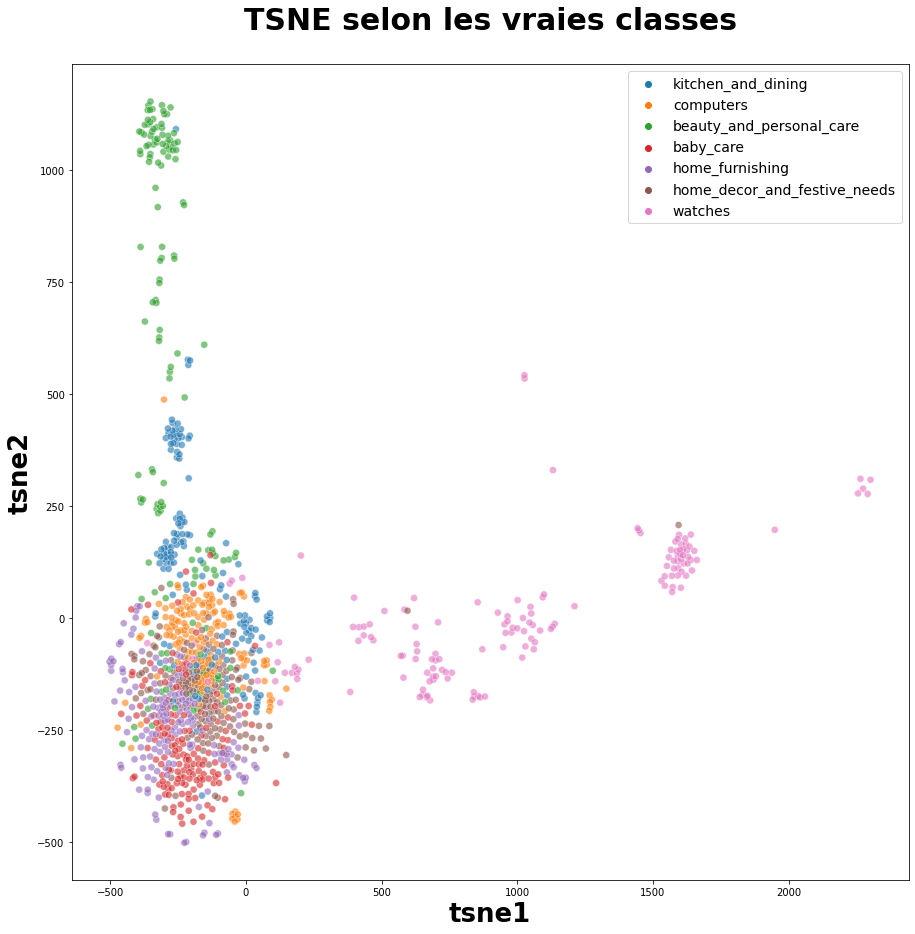

In [26]:
plt.figure(figsize=(15,15))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## <font color='blue'>Clustering</font>

In [27]:
real_cat = df_desc_img[['product_category']].copy()
real_cat.columns = ['category']

# Encodage des catégories trouvées manuellement
le = preprocessing.LabelEncoder()
real_cat['label_category'] = le.fit_transform(
    np.array(real_cat['category']))

real_cat

,category,label_category
0,kitchen_and_dining,5
1,computers,2
2,kitchen_and_dining,5
3,computers,2
4,computers,2
...,...,...
1045,kitchen_and_dining,5
1046,kitchen_and_dining,5
1047,computers,2
1048,beauty_and_personal_care,1


In [28]:
clust = df_desc_img.copy()

In [29]:
del clust['product_category']

In [30]:
km = KMeans(n_clusters=7,
            random_state=10,
            init='k-means++')

Exécution 
 
Nombre de lignes pris en compte pour le clustering 1050 
 

Qualité du Clustering 
 
 
Le coefficient de silhouette moyen est de 0.03533574578710247 pour la méthode k-means.
 
 
Le score ARI est de 0.10997431977087839 pour la méthode k-means. 
 

Visualisation 
 
 


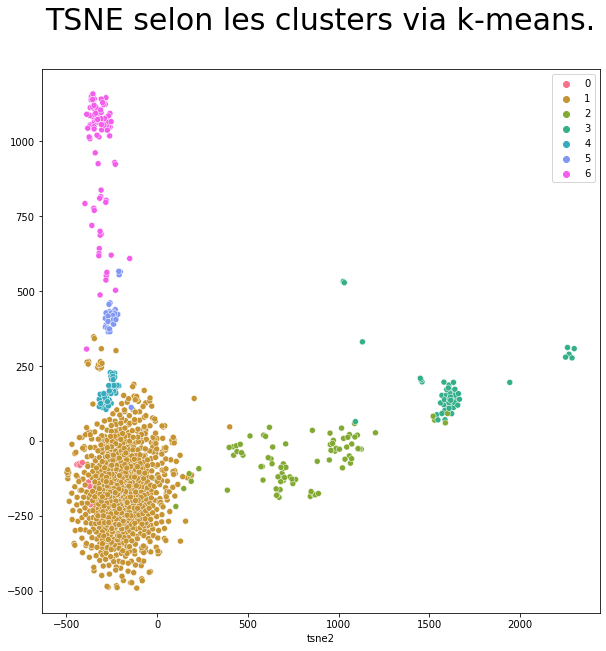

ARI :  0.10997431977087839

 



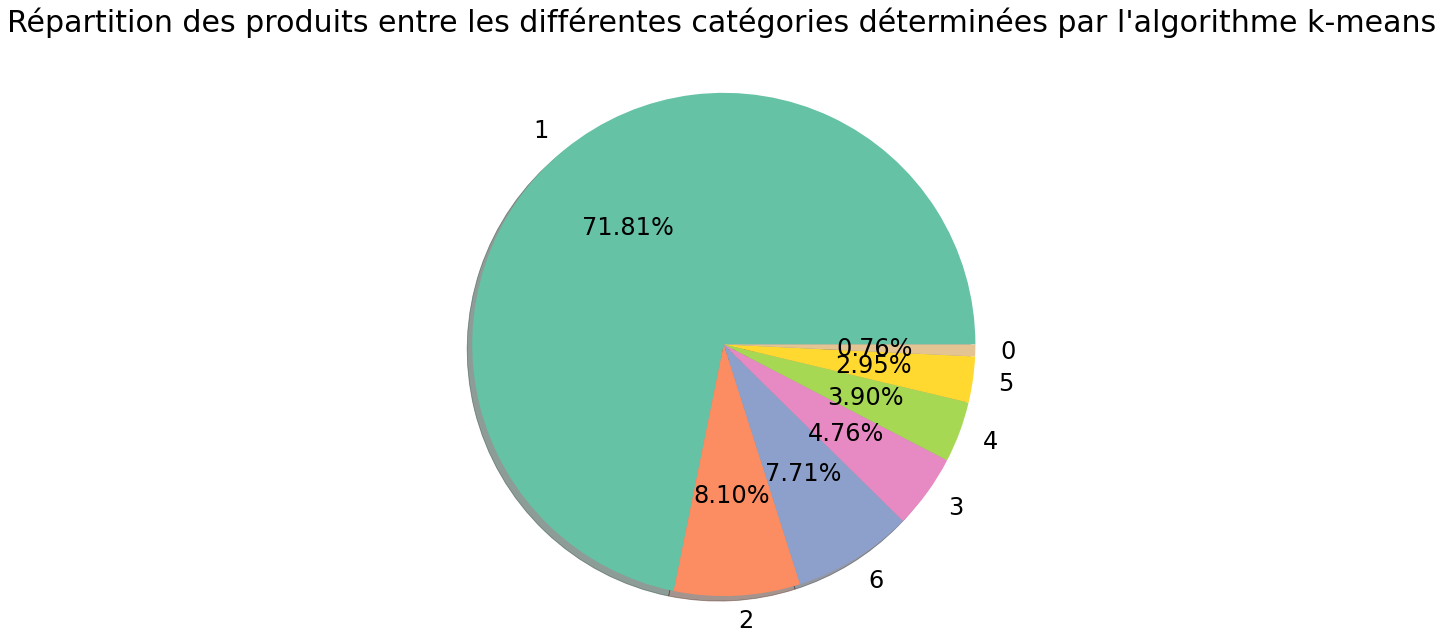

In [31]:
silhouette, ARI, tot_data_label = clustering(
    km, clust, real_cat['category'], real_cat['label_category'], 'k-means')

In [32]:
label = np.arange(tot_data_label['algo_cluster'].min(
), tot_data_label['algo_cluster'].max()+1, 1)
for i in range(len(label)):
    df = tot_data_label.loc[tot_data_label['algo_cluster'] == label.item(i)]
    cat = df['category'].unique()
    print('Dans le Cluster {} on retrouve des données réparties dans les catégories {} déterminées manuellement. \n \n' .format(label.item(i), cat))

Dans le Cluster 0 on retrouve des données réparties dans les catégories ['home_decor_and_festive_needs'] déterminées manuellement. 
 

Dans le Cluster 1 on retrouve des données réparties dans les catégories ['kitchen_and_dining' 'computers' 'beauty_and_personal_care' 'baby_care'
 'home_furnishing' 'home_decor_and_festive_needs' 'watches'] déterminées manuellement. 
 

Dans le Cluster 2 on retrouve des données réparties dans les catégories ['watches' 'computers' 'home_decor_and_festive_needs'] déterminées manuellement. 
 

Dans le Cluster 3 on retrouve des données réparties dans les catégories ['watches' 'home_decor_and_festive_needs'] déterminées manuellement. 
 

Dans le Cluster 4 on retrouve des données réparties dans les catégories ['kitchen_and_dining'] déterminées manuellement. 
 

Dans le Cluster 5 on retrouve des données réparties dans les catégories ['kitchen_and_dining'] déterminées manuellement. 
 

Dans le Cluster 6 on retrouve des données réparties dans les catégories ['bea

In [33]:
table = pd.pivot_table(tot_data_label, values='label_category', index=['category'],  # , 'category'
                       columns=['algo_cluster'], aggfunc=lambda x: len(x), fill_value=0)
table

algo_cluster,0,1,2,3,4,5,6
category,,,,,,,
baby_care,0,150,0,0,0,0,0
beauty_and_personal_care,0,71,0,0,0,0,79
computers,0,148,1,0,0,0,1
home_decor_and_festive_needs,8,140,1,1,0,0,0
home_furnishing,0,150,0,0,0,0,0
kitchen_and_dining,0,77,0,0,41,31,1
watches,0,18,83,49,0,0,0


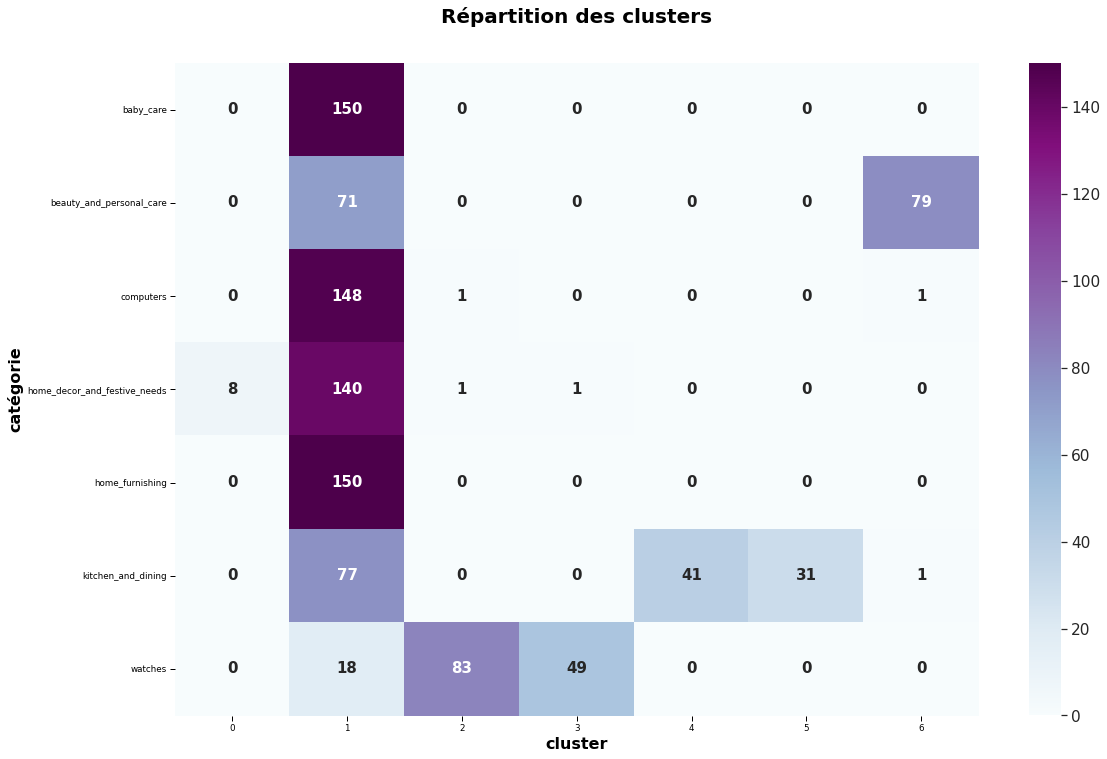

In [34]:
plt.figure(figsize=(18, 12))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(table, annot=True,
            cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=16)
plt.xlabel('cluster', weight='bold', size=16)
plt.show()

## <font color='blue'>Classification</font>

In [35]:
clas = df_desc_img.copy()
clas

,product_category,Feature BoW 0,Feature BoW 1,Feature BoW 2,Feature BoW 3,Feature BoW 4,Feature BoW 5,Feature BoW 6,Feature BoW 7,Feature BoW 8,Feature BoW 9,Feature BoW 10,Feature BoW 11,Feature BoW 12,Feature BoW 13,Feature BoW 14,Feature BoW 15,Feature BoW 16,Feature BoW 17,Feature BoW 18,Feature BoW 19,Feature BoW 20,Feature BoW 21,Feature BoW 22,Feature BoW 23,Feature BoW 24,Feature BoW 25,Feature BoW 26,Feature BoW 27,Feature BoW 28,Feature BoW 29,Feature BoW 30,Feature BoW 31,Feature BoW 32,Feature BoW 33,Feature BoW 34,Feature BoW 35,Feature BoW 36,Feature BoW 37,Feature BoW 38,...,Principal Component 705,Principal Component 706,Principal Component 707,Principal Component 708,Principal Component 709,Principal Component 710,Principal Component 711,Principal Component 712,Principal Component 713,Principal Component 714,Principal Component 715,Principal Component 716,Principal Component 717,Principal Component 718,Principal Component 719,Principal Component 720,Principal Component 721,Principal Component 722,Principal Component 723,Principal Component 724,Principal Component 725,Principal Component 726,Principal Component 727,Principal Component 728,Principal Component 729,Principal Component 730,Principal Component 731,Principal Component 732,Principal Component 733,Principal Component 734,Principal Component 735,Principal Component 736,Principal Component 737,Principal Component 738,Principal Component 739,Principal Component 740,Principal Component 741,Principal Component 742,Principal Component 743,Principal Component 744
0,kitchen_and_dining,-0.339980,-0.025793,0.005679,-0.140263,0.012972,0.074997,-0.104951,0.000566,0.101451,-0.080878,-0.154112,0.118541,-0.035400,-0.092311,-0.043119,0.081469,-0.096427,-0.140523,-0.106446,-0.152579,0.009416,0.012685,-0.093233,-0.049140,0.259795,-0.079259,0.029009,-0.172519,0.144775,-0.027043,-0.077028,-0.021914,0.001206,0.040653,-0.012717,-0.095813,-0.021391,-0.033565,0.015903,...,6.148522,15.640061,14.466612,5.936429,23.913778,-24.455269,0.139871,32.393299,-16.744816,14.453374,24.709017,30.439554,23.608690,15.866031,12.954233,25.530910,-11.406713,5.425672,2.792246,-30.092266,16.162081,-8.831730,35.533306,-3.042549,2.211890,3.587127,11.021719,-22.280632,3.457598,5.157306,2.124581,19.623446,-33.887367,-34.642109,-43.175449,2.065281,18.008556,-6.457664,-29.500772,-16.467255
1,computers,-0.256665,-0.025599,0.028749,-0.120884,-0.115659,0.143292,0.068201,0.008772,-0.038594,-0.048462,0.005605,-0.012013,-0.123944,0.162471,-0.085930,0.183013,0.059151,-0.037166,0.001953,0.028697,0.017873,-0.007790,-0.020623,-0.009332,0.012282,0.021142,0.000842,-0.013068,-0.082912,0.017034,-0.033047,-0.007560,0.075982,0.054751,-0.042843,0.008376,0.000181,0.057838,-0.036844,...,11.164635,-1.141047,22.735876,-11.940201,18.629704,0.376101,-21.022385,-54.023327,15.452373,36.954727,24.481157,28.885323,-19.505980,-56.684998,-19.985683,-24.673113,-44.748829,2.110186,38.367439,16.240841,8.756455,-19.059517,-9.810949,16.724016,-7.053120,3.373698,6.055670,-9.972054,44.336063,-9.181163,-38.705410,3.521884,-6.268561,13.212087,-5.783704,-31.471960,7.600857,4.468281,-6.836858,11.715006
2,kitchen_and_dining,-0.328396,-0.071964,0.067223,-0.199463,0.246863,-0.017311,-0.036504,-0.033853,0.190859,0.108532,-0.246304,0.004533,0.138933,0.042518,0.145234,0.126947,0.074518,0.082451,-0.018949,-0.158561,0.040966,-0.038422,-0.035194,-0.027334,0.002179,-0.015555,0.035402,-0.006429,-0.051570,0.061280,-0.083305,-0.039239,0.068163,-0.036956,-0.091305,0.029104,-0.161609,-0.011543,-0.035815,...,11.309206,0.086170,8.518536,-3.407748,-4.711069,30.375748,-9.915369,-16.242382,144.183701,59.215752,-28.354740,-45.383743,2.391144,37.978497,-50.373840,60.250198,20.214138,42.097466,86.568336,-26.212837,29.343777,-97.066612,46.611107,13.996102,-63.696247,44.594128,65.952034,5.744627,-42.785023,75.016960,-68.469208,55.255478,-2.305296,-55.930115,32.021023,-14.129154,-62.941692,-45.210991,0.177924,-16.385525
3,computers,-0.260871,-0.033179,0.004478,-0.103

In [36]:
X = df_desc_img.copy()
y = X['product_category']
X = X.drop(['product_category'], axis=1)
X = X[X.columns]

# Split en training/testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2  # 20% des données dans le jeu de test = 20% de short data
                                                    , random_state=42)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(840, 940) (210, 940) (840,) (210,)


In [38]:
X_train

,Feature BoW 0,Feature BoW 1,Feature BoW 2,Feature BoW 3,Feature BoW 4,Feature BoW 5,Feature BoW 6,Feature BoW 7,Feature BoW 8,Feature BoW 9,Feature BoW 10,Feature BoW 11,Feature BoW 12,Feature BoW 13,Feature BoW 14,Feature BoW 15,Feature BoW 16,Feature BoW 17,Feature BoW 18,Feature BoW 19,Feature BoW 20,Feature BoW 21,Feature BoW 22,Feature BoW 23,Feature BoW 24,Feature BoW 25,Feature BoW 26,Feature BoW 27,Feature BoW 28,Feature BoW 29,Feature BoW 30,Feature BoW 31,Feature BoW 32,Feature BoW 33,Feature BoW 34,Feature BoW 35,Feature BoW 36,Feature BoW 37,Feature BoW 38,Feature BoW 39,...,Principal Component 705,Principal Component 706,Principal Component 707,Principal Component 708,Principal Component 709,Principal Component 710,Principal Component 711,Principal Component 712,Principal Component 713,Principal Component 714,Principal Component 715,Principal Component 716,Principal Component 717,Principal Component 718,Principal Component 719,Principal Component 720,Principal Component 721,Principal Component 722,Principal Component 723,Principal Component 724,Principal Component 725,Principal Component 726,Principal Component 727,Principal Component 728,Principal Component 729,Principal Component 730,Principal Component 731,Principal Component 732,Principal Component 733,Principal Component 734,Principal Component 735,Principal Component 736,Principal Component 737,Principal Component 738,Principal Component 739,Principal Component 740,Principal Component 741,Principal Component 742,Principal Component 743,Principal Component 744
554,0.411593,-0.142149,0.055273,0.071734,0.062131,0.037200,0.062454,-0.049929,0.002497,-0.177154,-0.085568,-0.006086,0.027788,0.046110,0.076117,0.075876,-0.023385,0.011430,0.037460,-0.029933,0.029520,-0.042503,-0.006938,-0.026191,-0.039875,0.089383,0.010876,0.058425,0.109378,-0.073823,-0.072018,0.016045,0.005590,-0.018460,-0.060311,0.048676,-0.020503,-0.058625,0.024622,-0.030755,...,14.733184,53.974468,-2.439677,-79.391998,0.706478,-42.319801,-28.439482,-46.438690,77.272980,16.681646,13.521215,-41.438465,44.508385,55.380577,23.906401,22.899210,0.394397,8.927834,28.611715,9.771917,24.453600,47.269344,2.586154,-13.269295,-33.036812,-17.535114,52.685963,14.472110,-25.699553,-12.795409,14.823956,-46.210644,-20.973846,-45.091045,31.254028,68.969604,-19.857958,2.168565,21.536518,6.265702
1012,0.280723,0.604769,0.008418,0.027068,0.028359,-0.037113,0.036158,0.002870,-0.007666,0.006191,-0.066191,-0.338389,-0.053093,-0.085956,0.015872,0.047210,-0.040577,0.004663,-0.105423,-0.021939,0.048263,0.009345,-0.041923,0.027156,-0.005420,-0.083854,-0.166810,0.037885,0.066306,0.061876,-0.078499,0.031430,0.043992,-0.026934,-0.009999,0.011701,0.097911,-0.029633,-0.049911,0.005448,...,53.141247,45.370941,37.776299,-40.297855,16.681293,47.346512,18.639883,18.181091,-56.461449,-48.820663,7.158347,-5.855772,29.215967,59.507912,-4.812089,4.569281,-55.984459,70.032753,10.234904,17.993664,40.817402,-62.318634,46.098881,35.317131,-3.809689,58.539055,-17.583347,40.373013,-6.351864,45.264481,-11.733055,-14.406152,70.309753,-7.320618,4.235410,-32.449238,-53.965755,21.842785,-18.184975,-52.071007
481,0.112173,0.458942,0.009320,-0.004123,-0.000020,0.003548,0.009471,0.005248,-0.003231,0.022776,0.032140,-0.090624,-0.013139,0.008813,0.037484,0.044409,0.013294,-0.021801,0.159833,0.030562,-0.168128,-0.260110,0.135784,-0.190288,0.019457,-0.118879,-0.026154,-0.046107,-0.060601,0.026169,0.200709,-0.109496,-0.117279,0.089392,0.008441,-0.064431,-0.140110,0.066890,0.035200,0.011850,...,49.239323,49.678276,-31.806183,-49.405716,69.418556,-53.625313,29.226780,-67.035614,88.117943,24.395927,14.171588,-40.664288,33.639545,62.008461,-44.868626,62.370270,15.159027,-10.710902,-118.790054,-49.689110,49.949215,0.566607,-28.932396,-36.559410,27.194715,5.332634,52.401894,-31.925228,38.029049,-79.251450,-21.933222,-53.533470,-7.746166,45.166584,18.035309,-38.036129,10.001051,1.022986,-5.813988,-16.132393
432,0.147620,-0.115193,-0.069730,-0.125964,-0.132950,0.1

In [39]:
# GridSearch
param_grid = [{'max_depth': range(2, 10, 2)}]
gridSearch = GridSearchCV(RandomForestClassifier(),
                          param_grid, cv=5, scoring='accuracy')
score = 'accuracy'


# Fit sur le training set.
gridSearch.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = gridSearch.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    gridSearch.cv_results_['mean_test_score'],  # score moyen
    gridSearch.cv_results_['std_test_score'],  # écart-type du score
    gridSearch.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Résultats de la validation croisée :
accuracy = 0.844 (+/-0.040) for {'max_depth': 2}
accuracy = 0.864 (+/-0.050) for {'max_depth': 4}
accuracy = 0.871 (+/-0.059) for {'max_depth': 6}
accuracy = 0.886 (+/-0.047) for {'max_depth': 8}


Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.8714285714285714 pour la méthode Random Forest_combined.
 
 
Le score de précision est de 0.8857705129481971 pour la méthode Random Forest_combined.
 
 
Le score recall est de 0.8714285714285714 pour la méthode Random Forest_combined.
 
 
Le score f1 est de 0.8727511087100117 pour la méthode Random Forest_combined.
 
 
Visualisation 
 
 


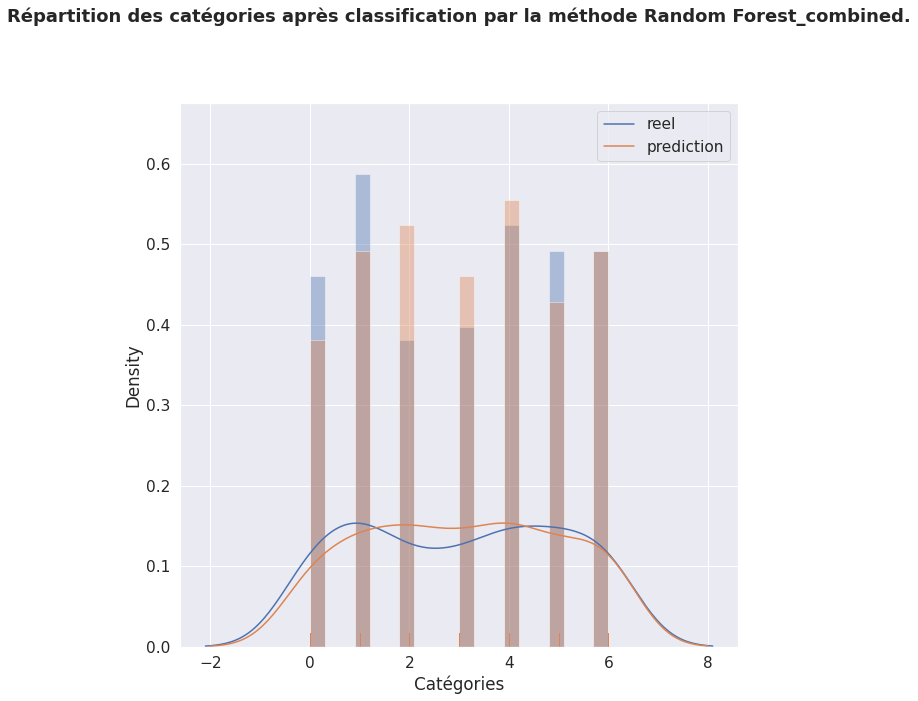

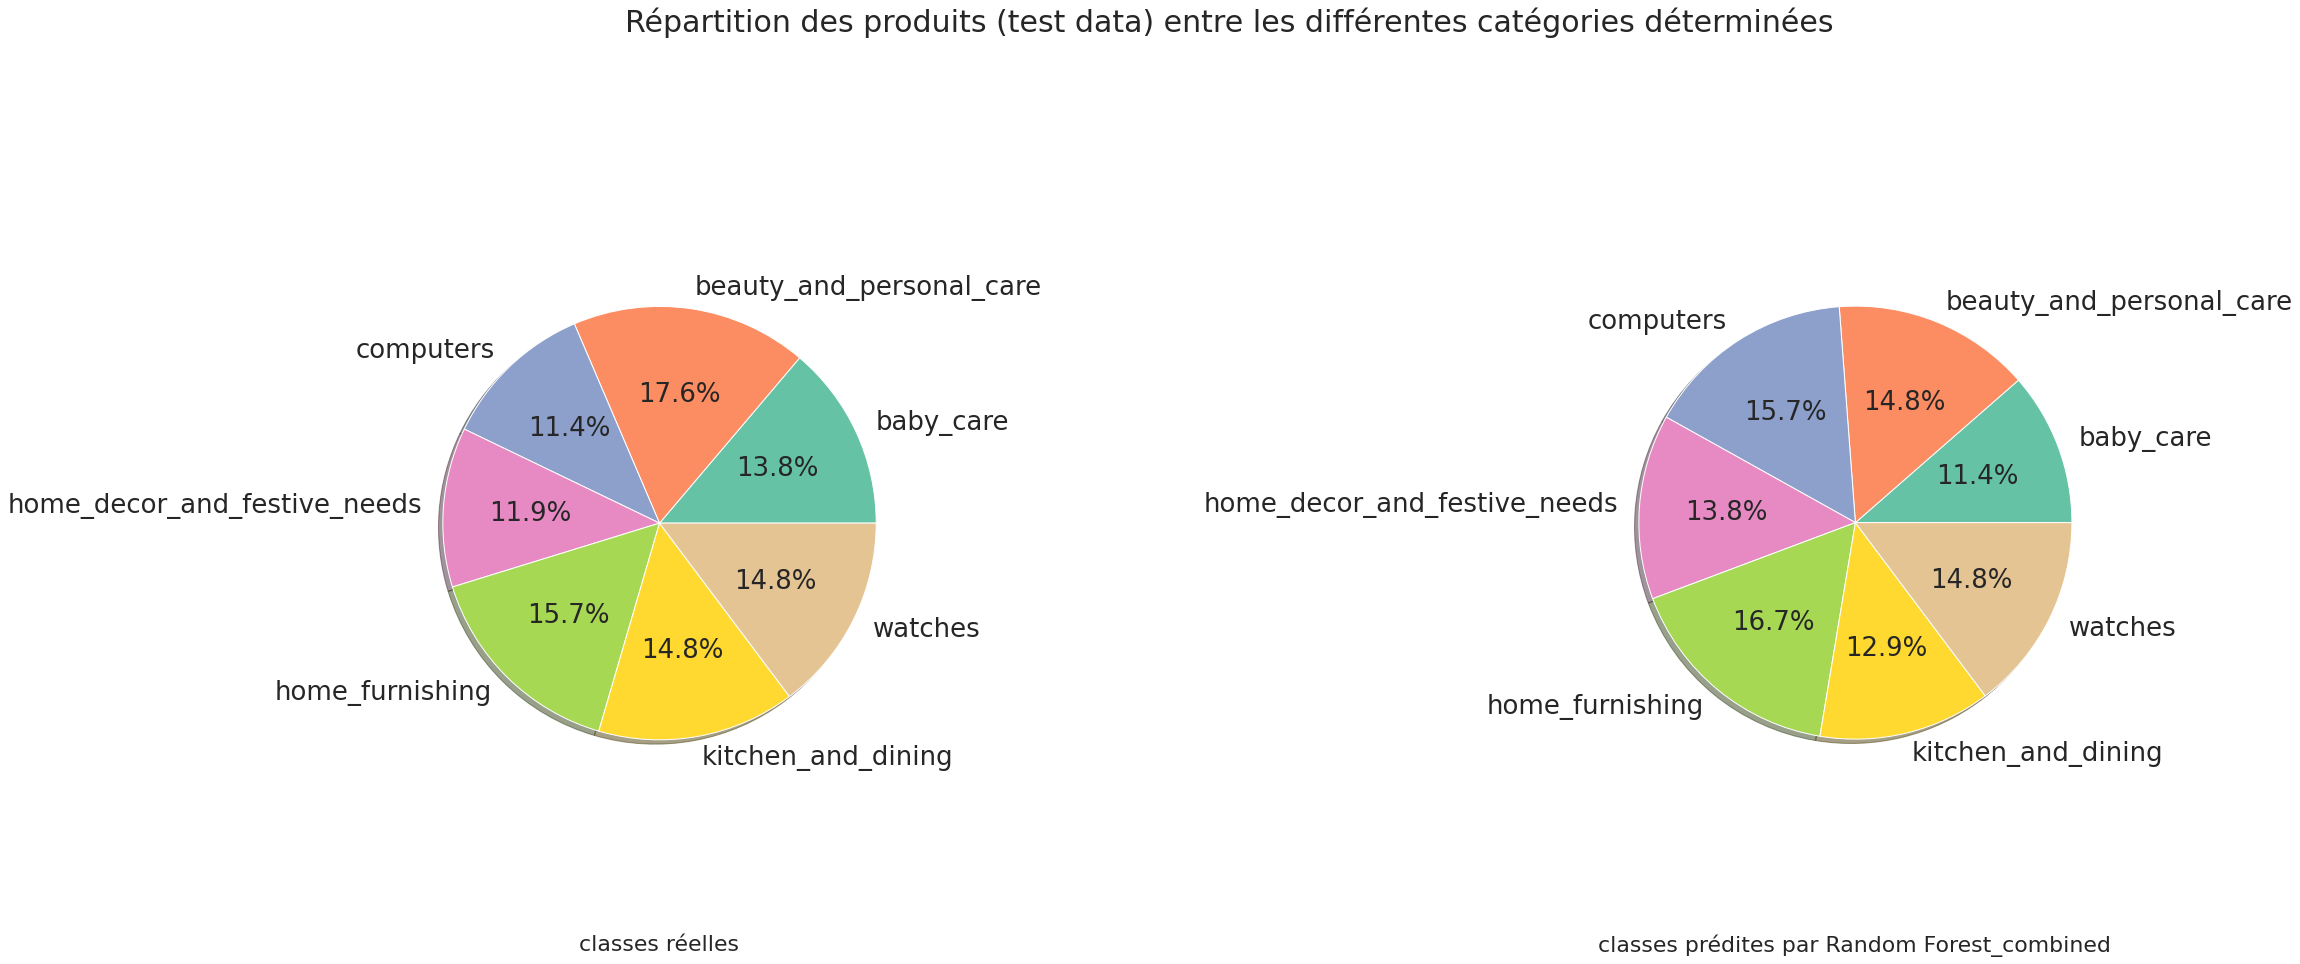

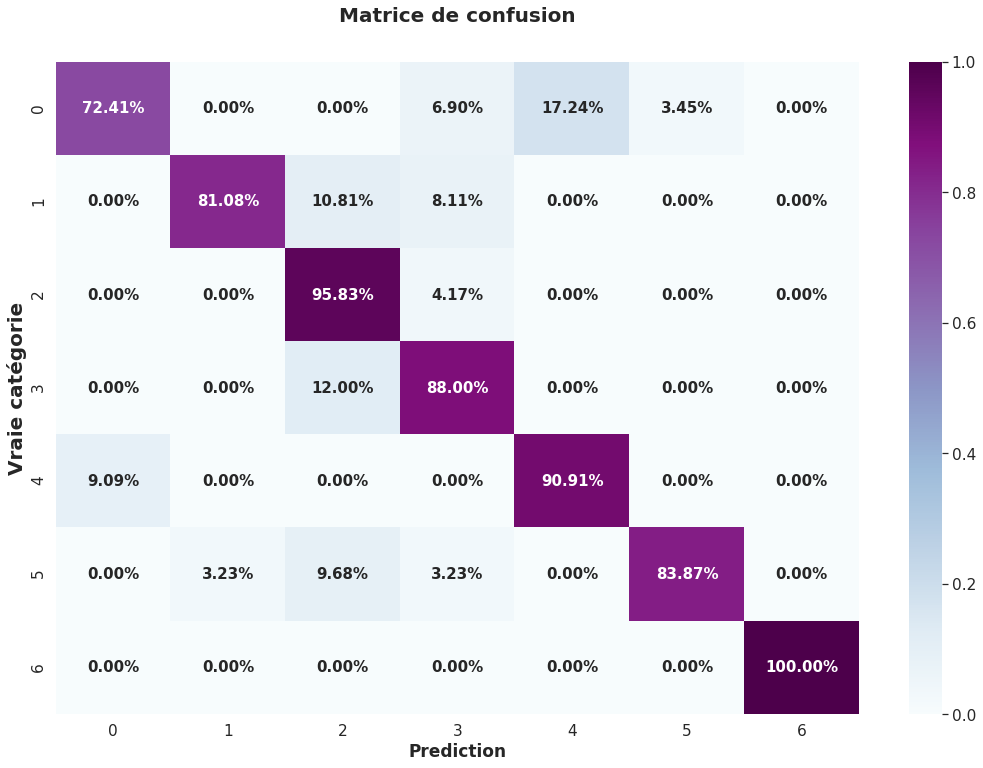

In [40]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, X_train, y_train, X_test, y_test, 'Random Forest_combined')

# <font color='green'>Quelles est l'influence des Descriptions et des images lors de la classification ?</font>

## <font color='blue'>Image uniquement : Choix du modèle CNN car meilleurs résultats au notebook 02</font>

### <font color='violet'>Mise en place des données</font>

In [41]:
# Path du dossier.
#folder = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Testing Set"
folder = "/content/drive/MyDrive/Data_projet_OC/Testing Set"

i = 0

# Liste contenant les catégories des images chargées
y_test_category = []
list_filename_test = []


for j in os.listdir(folder):

    folder_courant = folder + '/' + j

    for filename in os.listdir(folder_courant):

        y_test_category.append(j)

        # Path du fichier.
        path = folder_courant + '/' + filename

        list_filename_test.append(filename)

        # Charger l'image à la bonne dimension.
        img_resize = load_img(path, target_size=(224, 224))

        # Transformation de l'image en tableau numpy.
        img = img_to_array(img_resize)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

        # Preprocessing.
        img = preprocess_input(img)

        # Ajout de l'image à la liste de stockage.
        if (i == 0):
            x1 = img
            i = 1
        else:
            x1 = np.concatenate((x1, img), axis=0)

In [42]:
# Path du dossier.
#folder = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Testing Set"
folder = "/content/drive/MyDrive/Data_projet_OC/Training Set"

i = 0

# Liste contenant les catégories des images chargées
y_train_category = []
list_filename_train = []


for j in os.listdir(folder):

    folder_courant = folder + '/' + j

    for filename in os.listdir(folder_courant):

        y_train_category.append(j)

        # Path du fichier.
        path = folder_courant + '/' + filename
        list_filename_train.append(filename)

In [43]:
# Training Augmentation configuration
#base_dir = '/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/'
base_dir = '/content/drive/MyDrive/Data_projet_OC/'

batch_size = 32

train_dir = os.path.join(base_dir, 'Training Set')
test_dir = os.path.join(base_dir, 'Testing Set')


train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input)  # preprocessing_function=preprocess_input

# Testing Augmentation - Only Rescaling
test_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)  # preprocessing_function=preprocess_input

# Generates batches of Augmented Image data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Generator for validation data
validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(224, 224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 840 images belonging to 7 classes.
Found 210 images belonging to 7 classes.


### <font color='violet'>Exécution</font>

In [44]:
# load the model from disk
# load the model from disk
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive

loaded_model_image = keras.models.load_model("CNN_pictures_model")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [45]:
# Évaluation de la performance du modèle sur des données de test
loss, accuracy = loaded_model_image.evaluate(validation_generator)

print("\nModel's Evaluation Metrics: ")
print("---------------------------")
print("Accuracy: {} \nLoss: {}".format(accuracy, loss))

7/7 [==============================] - 66s 8s/step - loss: 0.9964 - accuracy: 0.7238

Model's Evaluation Metrics: 
---------------------------
Accuracy: 0.723809540271759 
Loss: 0.9964132905006409


Le CNN a atteint une précision de test de plus de 69%

### <font color='violet'>Prédiction</font>

In [46]:
# Prediction sur le testing Set.
proba_prediction_cnn = loaded_model_image.predict(x1, verbose=1)
proba_prediction_cnn

7/7 [==============================] - 54s 7s/step


array([[3.5158644e-16, 1.9895142e-12, 5.6425917e-36, ..., 9.3360141e-14,
        4.1952361e-20, 9.9999988e-01],
       [1.0000000e+00, 4.4294621e-21, 3.5592798e-22, ..., 1.5600742e-10,
        2.3367349e-08, 4.1835616e-13],
       [1.2955138e-04, 5.3446595e-08, 3.6717810e-07, ..., 4.3401320e-12,
        3.1956148e-19, 6.8199378e-04],
       ...,
       [1.1065733e-08, 3.2137439e-07, 9.8907872e-13, ..., 4.5997162e-08,
        4.5584309e-12, 9.9999964e-01],
       [6.8256165e-25, 2.3635848e-14, 9.3629671e-07, ..., 2.2708388e-34,
        7.7163473e-16, 9.9999905e-01],
       [2.1465370e-10, 5.6039959e-01, 4.3959931e-01, ..., 1.0048411e-06,
        1.1771001e-11, 5.8575228e-08]], dtype=float32)

In [47]:
proba_prediction_cnn_df = pd.DataFrame(proba_prediction_cnn)
proba_prediction_cnn_df

,0,1,2,3,4,5,6
0,3.515864e-16,1.989514e-12,5.642592e-36,1.162639e-07,9.336014e-14,4.195236e-20,9.999999e-01
1,1.000000e+00,4.429462e-21,3.559280e-22,5.423390e-12,1.560074e-10,2.336735e-08,4.183562e-13
2,1.295514e-04,5.344659e-08,3.671781e-07,9.991880e-01,4.340132e-12,3.195615e-19,6.819938e-04
3,9.994395e-01,3.186059e-19,1.044832e-18,1.830006e-10,5.603607e-04,4.191212e-10,1.637505e-07
4,9.996061e-06,3.635070e-29,3.694427e-22,1.744163e-17,9.999900e-01,0.000000e+00,2.200637e-16
...,...,...,...,...,...,...,...
205,1.317868e-19,3.254999e-06,9.929120e-01,3.787144e-09,3.761498e-18,3.211537e-22,7.084858e-03
206,3.774585e-04,6.613284e-05,9.995414e-01,4.782511e-18,2.947758e-10,2.041291e-07,1.481772e-05
207,1.106573e-08,3.213744e-07,9.890787e-13,1.462416e-08,4.599716e-08,4.558431e-12,9.999996e-01
208,6.825617e-25,2.363585e-14,9.362967e-07,2.147463e-11,2.270839e-34,7.716347e-16,9.999990e-01


In [48]:
list_filename_test_df = pd.DataFrame(list_filename_test)
list_filename_test_df.columns=["image"]
list_filename_test_df

,image
0,c9c4720bca91b8ce27d8190a7c4c139c.jpg
1,688bb32bf0d9b6e350d2c0912a3b7c9f.jpg
2,4e5ebfc871992e7e22365c0c036a1b89.jpg
3,7dd5e83e2108a97659577e50879f9d9f.jpg
4,634c89325a6c7752985a74a67f985c1f.jpg
...,...
205,6634de7b39a5b0658c74ab098450096d.jpg
206,54754ccd18f2a75c53de68806176392a.jpg
207,4354b7418ee0fab2fd9f8eb493556529.jpg
208,1eda39f01d0a8a2e5ce4b32fc7da1027.jpg


In [49]:
proba_image = pd.concat([list_filename_test_df, proba_prediction_cnn_df], axis=1)
proba_image

,image,0,1,2,3,4,5,6
0,c9c4720bca91b8ce27d8190a7c4c139c.jpg,3.515864e-16,1.989514e-12,5.642592e-36,1.162639e-07,9.336014e-14,4.195236e-20,9.999999e-01
1,688bb32bf0d9b6e350d2c0912a3b7c9f.jpg,1.000000e+00,4.429462e-21,3.559280e-22,5.423390e-12,1.560074e-10,2.336735e-08,4.183562e-13
2,4e5ebfc871992e7e22365c0c036a1b89.jpg,1.295514e-04,5.344659e-08,3.671781e-07,9.991880e-01,4.340132e-12,3.195615e-19,6.819938e-04
3,7dd5e83e2108a97659577e50879f9d9f.jpg,9.994395e-01,3.186059e-19,1.044832e-18,1.830006e-10,5.603607e-04,4.191212e-10,1.637505e-07
4,634c89325a6c7752985a74a67f985c1f.jpg,9.996061e-06,3.635070e-29,3.694427e-22,1.744163e-17,9.999900e-01,0.000000e+00,2.200637e-16
...,...,...,...,...,...,...,...,...
205,6634de7b39a5b0658c74ab098450096d.jpg,1.317868e-19,3.254999e-06,9.929120e-01,3.787144e-09,3.761498e-18,3.211537e-22,7.084858e-03
206,54754ccd18f2a75c53de68806176392a.jpg,3.774585e-04,6.613284e-05,9.995414e-01,4.782511e-18,2.947758e-10,2.041291e-07,1.481772e-05
207,4354b7418ee0fab2fd9f8eb493556529.jpg,1.106573e-08,3.213744e-07,9.890787e-13,1.462416e-08,4.599716e-08,4.558431e-12,9.999996e-01
208,1eda39f01d0a8a2e5ce4b32fc7da1027.jpg,6.825617e-25,2.363585e-14,9.362967e-07,2.147463e-11,2.270839e-34,7.716347e-16,9.999990e-01


In [50]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

open_file = open("proba_prediction_image_cnn.pkl", "wb")
pickle.dump(proba_prediction_cnn, open_file)
open_file.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [51]:
y_classes = [np.argmax(element) for element in proba_prediction_cnn]
y_classes[:5]

[6, 0, 3, 0, 4]

In [52]:
df = pd.DataFrame(y_classes, columns=['predict_category'])
df

,predict_category
0,6
1,0
2,3
3,0
4,4
...,...
205,2
206,2
207,6
208,6


In [53]:
dico_categ = {0: 'baby_care',
              1: 'beauty_and_personal_care',
              2: 'computers',
              3: 'home_decor_and_festive_needs',
              4: 'home_furnishing',
              5: 'kitchen_and_dining',
              6: 'watches'}

In [54]:
df = df.replace({"predict_category": dico_categ})
df

,predict_category
0,watches
1,baby_care
2,home_decor_and_festive_needs
3,baby_care
4,home_furnishing
...,...
205,computers
206,computers
207,watches
208,watches


In [55]:
#df.to_csv('y_test_image_predict_cnn.csv', index=False)

# sur google colab
from google.colab import drive
drive.mount('/content/drive')
df.to_csv('y_test_image_predict_cnn.csv', index=False)
!cp y_test_image_predict_cnn.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: 'y_test_image_predict_cnn.csv' and '/content/drive/My Drive/y_test_image_predict_cnn.csv' are the same file


In [56]:
df1 = pd.DataFrame(y_test_category, columns=['product_category'])
df1['product_category'] = df1['product_category'].str.replace(
    "'", '')
df1

,product_category
0,baby_care
1,baby_care
2,baby_care
3,baby_care
4,baby_care
...,...
205,computers
206,computers
207,computers
208,computers


In [57]:
resume_cnn = pd.concat([df, df1], axis=1)
resume_cnn

,predict_category,product_category
0,watches,baby_care
1,baby_care,baby_care
2,home_decor_and_festive_needs,baby_care
3,baby_care,baby_care
4,home_furnishing,baby_care
...,...,...
205,computers,computers
206,computers,computers
207,watches,computers
208,watches,computers


### <font color='violet'>Qualité de la prédiction</font>

In [58]:
# Qualité de la classification
accuracy = accuracy_score(
    resume_cnn['product_category'], resume_cnn['predict_category'])
print('L\'accuracy score est de {} \n \n '.format(
    accuracy))
precision = precision_score(
    resume_cnn['product_category'], resume_cnn['predict_category'], average='weighted')
print('La score précision est de {} \n \n '.format(
    precision))
recall = recall_score(resume_cnn['product_category'],
                      resume_cnn['predict_category'], average='weighted')
print('Le score recall est de {} \n \n '.format(
    recall))
f1 = f1_score(resume_cnn['product_category'],
              resume_cnn['predict_category'], average='weighted')
print('Le score f1 est de {} \n \n '.format(
    f1))

L'accuracy score est de 0.5857142857142857 
 
 
La score précision est de 0.6405181700101799 
 
 
Le score recall est de 0.5857142857142857 
 
 
Le score f1 est de 0.5694621198387979 
 
 


Ici le score d'accuracy est de 0.58 ce qui montre que la classification fonctionne bien avec une très grande précision.

Ici le score de précision est de 0.64 montre que la prédiction est assez précise car le score est proche de 1.

Ici le score f1 est de 0.56 montre que la prédiction fait en majorité des vrais positifs car le score est proche de 1.

In [59]:
le = preprocessing.LabelEncoder()
resume_cnn['label_cat_reel'] = le.fit_transform(
    np.array(resume_cnn['product_category']))
resume_cnn['label_cat_predit'] = le.transform(
    np.array(resume_cnn['predict_category']))
resume_cnn

,predict_category,product_category,label_cat_reel,label_cat_predit
0,watches,baby_care,0,6
1,baby_care,baby_care,0,0
2,home_decor_and_festive_needs,baby_care,0,3
3,baby_care,baby_care,0,0
4,home_furnishing,baby_care,0,4
...,...,...,...,...
205,computers,computers,2,2
206,computers,computers,2,2
207,watches,computers,2,6
208,watches,computers,2,6


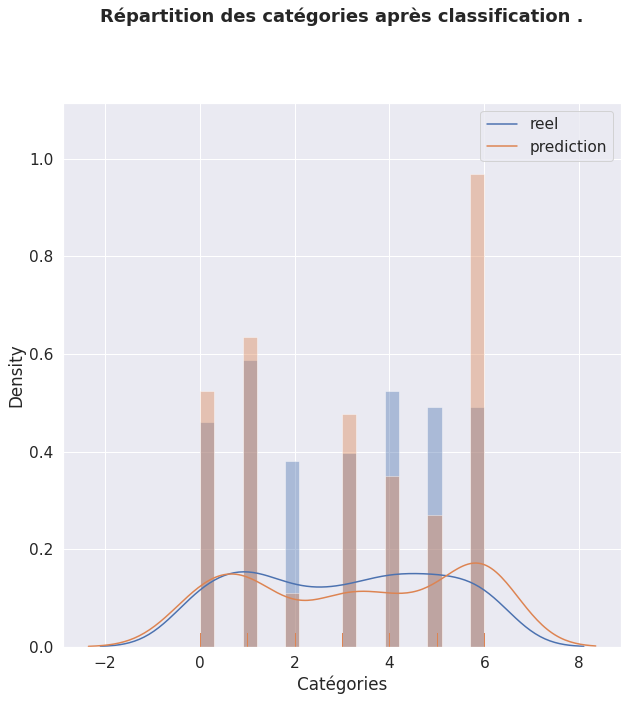

In [60]:
plt.figure(figsize=(10, 10))
plt.title('Répartition des catégories après classification .\n \n ',
          fontsize=18, fontweight="bold")
sns.distplot(resume_cnn['label_cat_reel'], bins=20, rug=True)
sns.distplot(resume_cnn['label_cat_predit'], bins=20, rug=True)
plt.xlabel("Catégories")
plt.legend(['reel', 'prediction'])

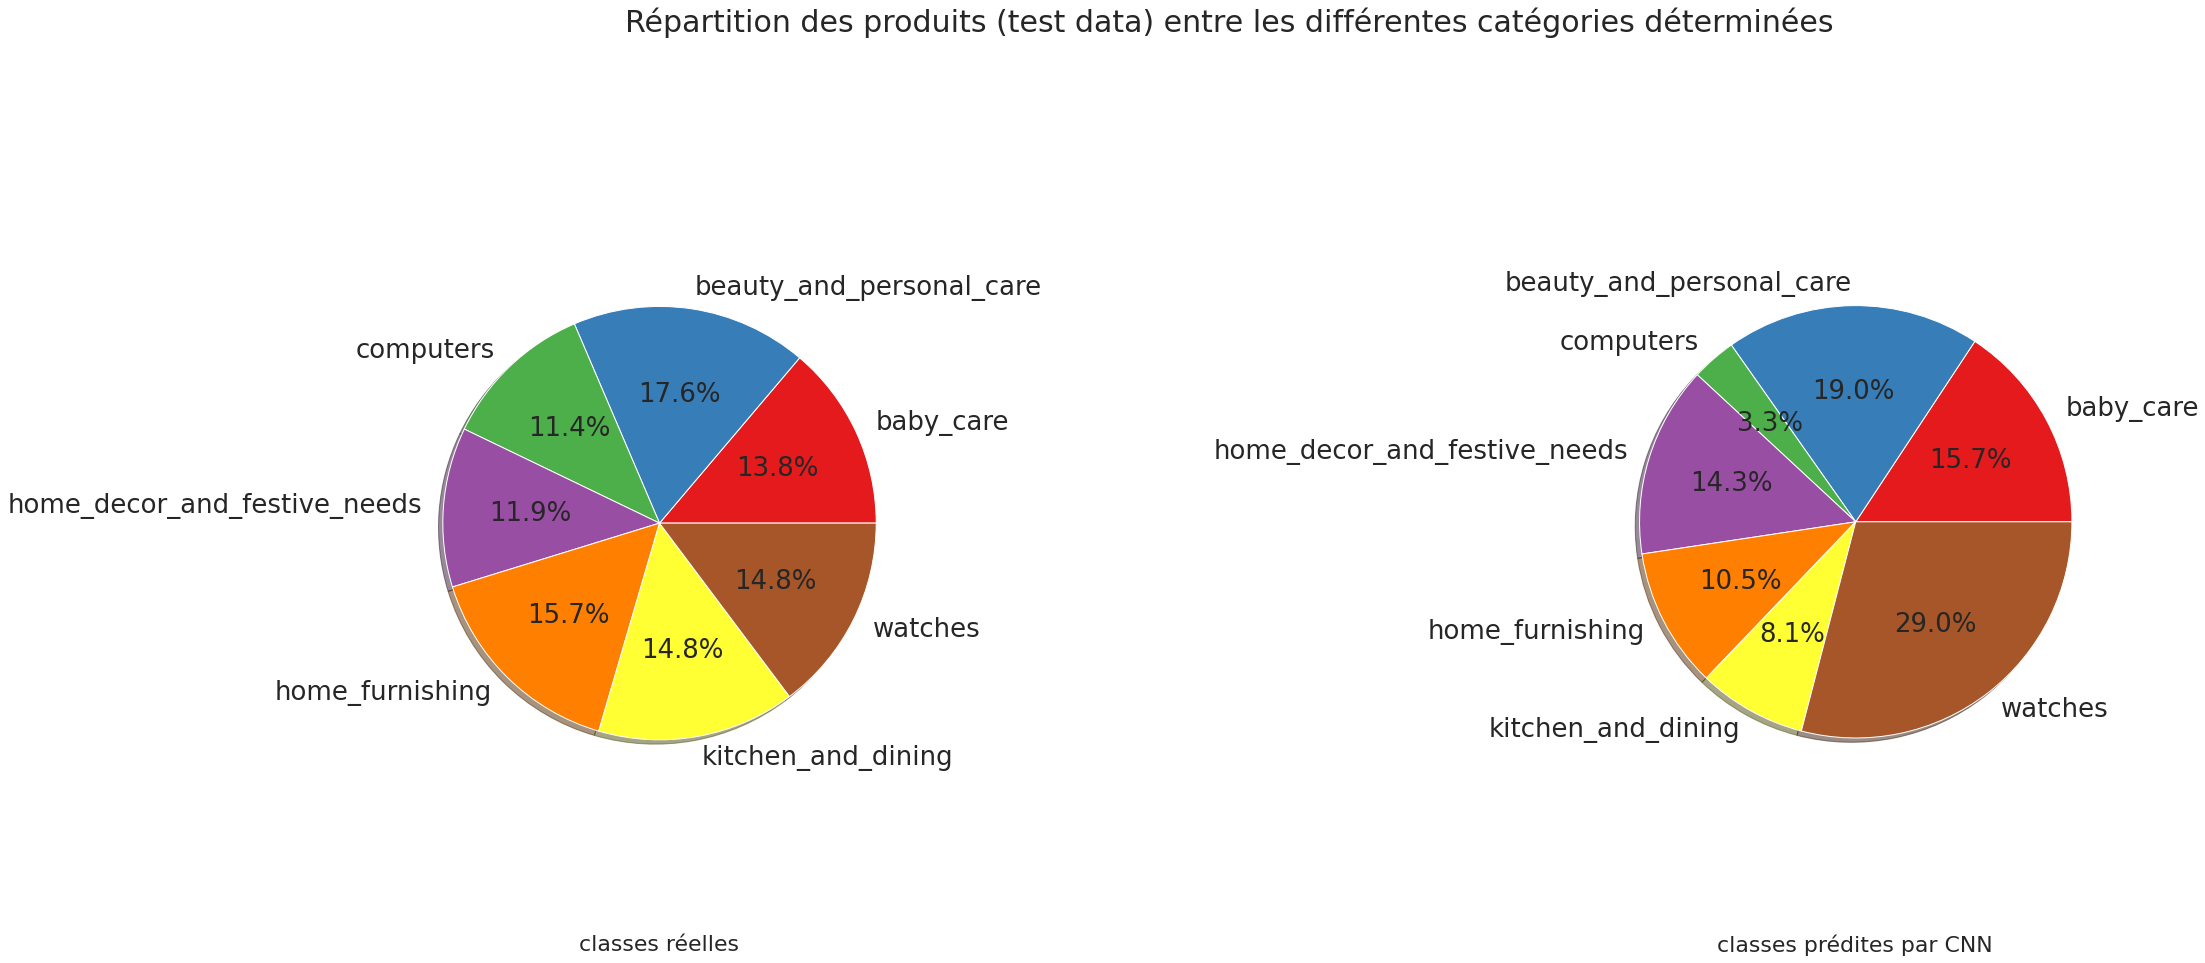

In [61]:
from matplotlib import cm
fig = plt.figure(figsize=(30, 15))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
nb_label_real = resume_cnn['product_category'].nunique()
cs_nb_label_real = cm.Set1(np.arange(nb_label_real))
nb_label_predit = resume_cnn['predict_category'].nunique()
cs_nb_label_predit = cm.Set1(np.arange(nb_label_predit))

ax1 = resume_cnn.groupby('product_category').count().plot(kind='pie',
                                                          y='label_cat_reel',
                                                          ax=ax1,
                                                          legend=False,
                                                          shadow=True,
                                                          startangle=0,
                                                          autopct='%1.1f%%',
                                                          textprops={
                                                               'fontsize': 26},
                                                          colors=cs_nb_label_real)
ax1.axis('equal')
ax1.set_xlabel("classes réelles", fontsize=22)
ax1.set_ylabel(" ")

ax2 = resume_cnn.groupby('predict_category').count().plot(kind='pie',
                                                          y='label_cat_predit',
                                                          ax=ax2,
                                                          legend=False,
                                                          shadow=True,
                                                          startangle=0,
                                                          autopct='%1.1f%%',
                                                          textprops={
                                                               'fontsize': 26},
                                                          colors=cs_nb_label_predit)
ax2.axis('equal')
ax2.set_xlabel("classes prédites par CNN", fontsize=22)
ax2.set_ylabel(" ")

plt.suptitle('Répartition des produits (test data) entre les différentes catégories déterminées',
             fontsize=30)

plt.subplots_adjust(wspace=1.5)

plt.show()

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les catégories 0, 1 et 5, le CNN regroupe moins de produits dans ces catégories par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 2, 3 et 4. Pour la catégorie 6, le CNN predit autant de produit qu’en réalité.

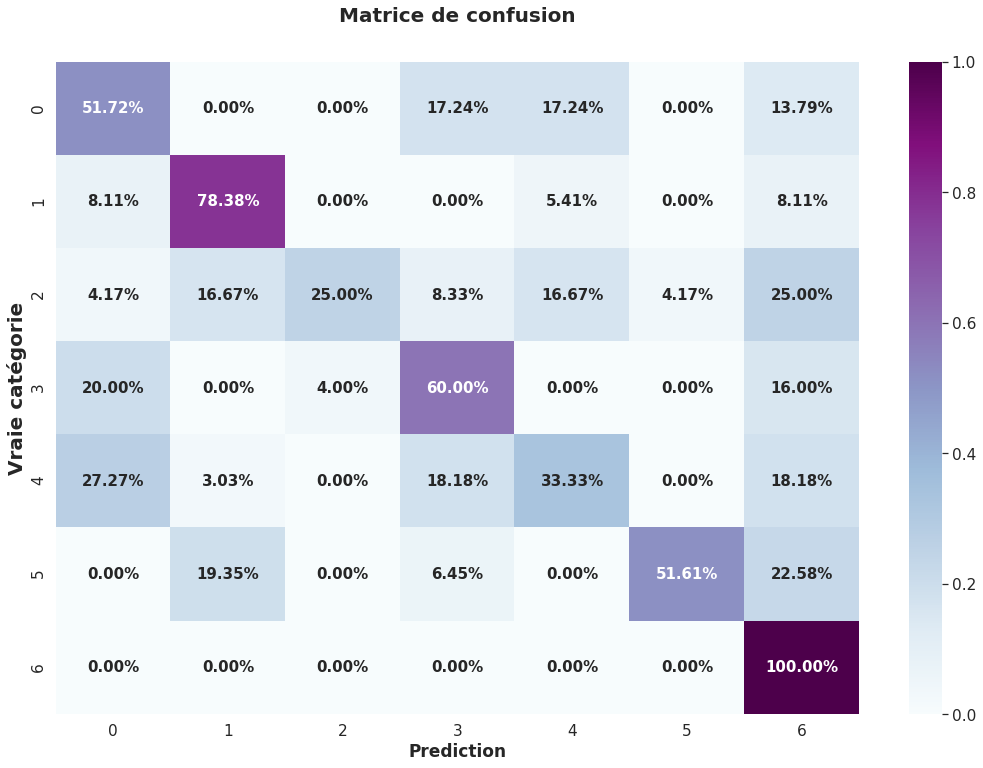

In [62]:
cf_matrix = confusion_matrix(
    resume_cnn["product_category"], resume_cnn["predict_category"], normalize='true')
plt.figure(figsize=(18, 12))
plt.title('Matrice de confusion', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cf_matrix, annot=True,
            fmt='.2%', cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'})
plt.ylabel("Vraie catégorie", weight='bold', size=20)
plt.xlabel('Prediction', weight='bold', size=17)
plt.show()

L'algorithme se trompe surtout sur la prédiction des clusters 2, 3 et 4.

## <font color='blue'>Description uniquement</font>

### <font color='violet'>Importation des descriptions</font>

In [63]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Data_projet_OC
!ls

data = pd.read_csv(
    '/content/drive/MyDrive/Data_projet_OC/df_untokenize_description.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Data_projet_OC
 cheval.png			 Flipkart	  X_train_nt3.csv
 df_tfidfvect.csv		'Testing Set'	  y_test_nt3.csv
 df_tfidfvect_total.csv		'Training Set'	  y_train_nt3.csv
 df_untokenize_description.csv	 X_test_nt3.csv


In [64]:
data.head()

,image,category,label_category,description_untokenize_clean
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home_furnishing,4,feature elegance polyester multicolor abstract...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby_care,0,specification sathiyas cotton bath towel bath ...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby_care,0,feature eurospa cotton terry face towel size s...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home_furnishing,4,feature santosh royal fashion cotton printed k...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home_furnishing,4,feature jaipur print cotton floral king sized ...


### <font color='violet'>Séparation en train/test en fonction de la séparation des images réalisée au notebook précédent</font>

#### <font color='grey'>Train</font>

In [65]:
train_set = data[data['image'].isin(list_filename_train)]
train_set

,image,category,label_category,description_untokenize_clean
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home_furnishing,4,feature elegance polyester multicolor abstract...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby_care,0,feature eurospa cotton terry face towel size s...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home_furnishing,4,feature santosh royal fashion cotton printed k...
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,watches,6,maserati time analog watch boy maserati time a...
6,f355cc1ccb08bd0d283ed979b7ee7515.jpg,watches,6,camerii elegance analog watch boy camerii eleg...
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby_care,0,oren empower extra large self adhesive sticker...
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,baby_care,0,wallmantra large vinyl sticker sticker pack pr...
1047,5912e037d12774bb73a2048f35a00009.jpg,baby_care,0,uberlyfe extra large pigmented polyvinyl film ...
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,baby_care,0,wallmantra medium vinyl sticker sticker online...


In [66]:
list_filename_train_df = pd.DataFrame(list_filename_train)
list_filename_train_df.columns=["image"]
list_filename_train_df

,image
0,ce9cb60201f1cdc33e4b58d3583c7a5c.jpg
1,83b7c331ebdd018bea7cecb6171eda96.jpg
2,b2e4a7feb6bbca9cca2c0c1e18acbcfc.jpg
3,ee27bc4719ae58c5cb3f1dede61fcf54.jpg
4,00cbbc837d340fa163d11e169fbdb952.jpg
...,...
835,b4d35b6536b623c83b293eb3a1c02bba.jpg
836,209bf06a732416f1ce5147a8b0524808.jpg
837,a43fbae655e5d13215b9dd65339fa9d4.jpg
838,f3ad282dac6ef0e30585a49ac67a322b.jpg


In [67]:
training_set_ordered = pd.merge(
    list_filename_train_df, train_set, left_on='image', right_on='image')
training_set_ordered

,image,category,label_category,description_untokenize_clean
0,ce9cb60201f1cdc33e4b58d3583c7a5c.jpg,home_furnishing,4,handloomhub polyester baby pink self design ey...
1,83b7c331ebdd018bea7cecb6171eda96.jpg,home_furnishing,4,home original geometric striped double blanket...
2,b2e4a7feb6bbca9cca2c0c1e18acbcfc.jpg,home_furnishing,4,rajasthan craft abstract single quilt comforte...
3,ee27bc4719ae58c5cb3f1dede61fcf54.jpg,home_furnishing,4,jaipur raga floral double quilt comforter flip...
4,00cbbc837d340fa163d11e169fbdb952.jpg,home_furnishing,4,flazee home trend beige table runner flipkart ...
...,...,...,...,...
835,b4d35b6536b623c83b293eb3a1c02bba.jpg,computers,2,feature slim multimedia flexible wired flexibl...
836,209bf06a732416f1ce5147a8b0524808.jpg,computers,2,lapguard toshiba satellite cell laptop battery...
837,a43fbae655e5d13215b9dd65339fa9d4.jpg,computers,2,huawei mbps wireless range extender flipkart g...
838,f3ad282dac6ef0e30585a49ac67a322b.jpg,computers,2,edimax flipkart genuine product replacement gu...


In [68]:
X = training_set_ordered.copy()
y_train = X['category']
X_train = X.drop(['category'], axis=1)

In [69]:
y_train

0      home_furnishing
1      home_furnishing
2      home_furnishing
3      home_furnishing
4      home_furnishing
            ...       
835          computers
836          computers
837          computers
838          computers
839          computers
Name: category, Length: 840, dtype: object

In [70]:
X_train

,image,label_category,description_untokenize_clean
0,ce9cb60201f1cdc33e4b58d3583c7a5c.jpg,4,handloomhub polyester baby pink self design ey...
1,83b7c331ebdd018bea7cecb6171eda96.jpg,4,home original geometric striped double blanket...
2,b2e4a7feb6bbca9cca2c0c1e18acbcfc.jpg,4,rajasthan craft abstract single quilt comforte...
3,ee27bc4719ae58c5cb3f1dede61fcf54.jpg,4,jaipur raga floral double quilt comforter flip...
4,00cbbc837d340fa163d11e169fbdb952.jpg,4,flazee home trend beige table runner flipkart ...
...,...,...,...
835,b4d35b6536b623c83b293eb3a1c02bba.jpg,2,feature slim multimedia flexible wired flexibl...
836,209bf06a732416f1ce5147a8b0524808.jpg,2,lapguard toshiba satellite cell laptop battery...
837,a43fbae655e5d13215b9dd65339fa9d4.jpg,2,huawei mbps wireless range extender flipkart g...
838,f3ad282dac6ef0e30585a49ac67a322b.jpg,2,edimax flipkart genuine product replacement gu...


In [71]:
#X_train.to_csv('X_train_description.csv', index=False)

# sur google colab
from google.colab import drive
drive.mount('/content/drive')
X_train.to_csv('X_train_nt3.csv', index=False)
!cp X_train_nt3.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
#y_train.to_csv('y_train_description.csv', index=False)

# sur google colab
from google.colab import drive
drive.mount('/content/drive')
y_train.to_csv('y_train_nt3.csv', index=False)
!cp y_train_nt3.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### <font color='grey'>Test</font>

In [73]:
test_set = data[data['image'].isin(list_filename_test)]
test_set

,image,category,label_category,description_untokenize_clean
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby_care,0,specification sathiyas cotton bath towel bath ...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home_furnishing,4,feature jaipur print cotton floral king sized ...
7,dd0e3470a7e6ed76fd69c2da27721041.jpg,watches,6,star analog watch boy price whether work trave...
8,41384da51732c0b4df3de8f395714fbb.jpg,watches,6,alfajr youth digital watch boy alfajr youth di...
18,62c35de4df27437d3597963fac55a8b6.jpg,watches,6,franck bella analog watch boy franck bella ana...
...,...,...,...,...
1019,031c98cfde349d99fb6d5983f54c8751.jpg,computers,2,feature print shape power roman reign laptop s...
1032,b5834f1e97c74d2833dbcb09a3f27926.jpg,computers,2,feature print shape mary cartoon laptop skin m...
1033,ace154420a51fad090b3543995630051.jpg,home_furnishing,4,feature aroma comfort polyester dark blue plai...
1036,5a54c78b52c984e56500809e5bc27ae1.jpg,computers,2,feature print shape bull laptop skin mouse com...


In [74]:
testing_set_ordered = pd.merge(
    list_filename_test_df, test_set, left_on='image', right_on='image')
testing_set_ordered

,image,category,label_category,description_untokenize_clean
0,c9c4720bca91b8ce27d8190a7c4c139c.jpg,baby_care,0,blue bell popfun sipper online blue bell popfu...
1,688bb32bf0d9b6e350d2c0912a3b7c9f.jpg,baby_care,0,feature little lamb baby girl gathered dress l...
2,4e5ebfc871992e7e22365c0c036a1b89.jpg,baby_care,0,feature mini klub baby bodysuit fabric cotton ...
3,7dd5e83e2108a97659577e50879f9d9f.jpg,baby_care,0,specification toffyhouse baby sleepsuit genera...
4,634c89325a6c7752985a74a67f985c1f.jpg,baby_care,0,feature sparkling cotton checkered double beds...
...,...,...,...,...
205,6634de7b39a5b0658c74ab098450096d.jpg,computers,2,link wireless dual band router flipkart genuin...
206,54754ccd18f2a75c53de68806176392a.jpg,computers,2,netis flipkart genuine product replacement gua...
207,4354b7418ee0fab2fd9f8eb493556529.jpg,computers,2,memore portable flexible mmull white light whi...
208,1eda39f01d0a8a2e5ce4b32fc7da1027.jpg,computers,2,iball flipkart genuine product replacement gua...


In [75]:
X = testing_set_ordered.copy()
y_test = X['category']
X_test = X.drop(['category'], axis=1)

In [76]:
y_test

0      baby_care
1      baby_care
2      baby_care
3      baby_care
4      baby_care
         ...    
205    computers
206    computers
207    computers
208    computers
209    computers
Name: category, Length: 210, dtype: object

In [77]:
X_test

,image,label_category,description_untokenize_clean
0,c9c4720bca91b8ce27d8190a7c4c139c.jpg,0,blue bell popfun sipper online blue bell popfu...
1,688bb32bf0d9b6e350d2c0912a3b7c9f.jpg,0,feature little lamb baby girl gathered dress l...
2,4e5ebfc871992e7e22365c0c036a1b89.jpg,0,feature mini klub baby bodysuit fabric cotton ...
3,7dd5e83e2108a97659577e50879f9d9f.jpg,0,specification toffyhouse baby sleepsuit genera...
4,634c89325a6c7752985a74a67f985c1f.jpg,0,feature sparkling cotton checkered double beds...
...,...,...,...
205,6634de7b39a5b0658c74ab098450096d.jpg,2,link wireless dual band router flipkart genuin...
206,54754ccd18f2a75c53de68806176392a.jpg,2,netis flipkart genuine product replacement gua...
207,4354b7418ee0fab2fd9f8eb493556529.jpg,2,memore portable flexible mmull white light whi...
208,1eda39f01d0a8a2e5ce4b32fc7da1027.jpg,2,iball flipkart genuine product replacement gua...


In [78]:
#X_ttest.to_csv('X_test_description.csv', index=False)

# sur google colab
from google.colab import drive
drive.mount('/content/drive')
X_test.to_csv('X_test_nt3.csv', index=False)
!cp X_test_nt3.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
#y_test.to_csv('y_test_description.csv', index=False)

# sur google colab
from google.colab import drive
drive.mount('/content/drive')
y_test.to_csv('y_test_nt3.csv', index=False)
!cp y_test_nt3.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <font color='violet'>tfidf</font>

In [80]:
import nltk
stopwords = list(set(STOPWORDS))
stopwords = [l.lower() for l in list(stopwords)]
alphabet_string = list(string.ascii_lowercase)
nltk.download('stopwords')
english_stop = nltk.corpus.stopwords.words('english')
english_stop = [l.lower() for l in list(english_stop)]
all_stopwords = set(stopwords + alphabet_string + english_stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
tfidfvectorizer = TfidfVectorizer(encoding='utf-8',
                                  strip_accents=None,
                                  lowercase=True,
                                  preprocessor=None,
                                  tokenizer=None,
                                  analyzer='word',
                                  stop_words=all_stopwords,
                                  max_df=0.95,
                                  min_df=0.01)

#### <font color='olive'>tfidf train set</font>

In [82]:
X_train.head()

,image,label_category,description_untokenize_clean
0,ce9cb60201f1cdc33e4b58d3583c7a5c.jpg,4,handloomhub polyester baby pink self design ey...
1,83b7c331ebdd018bea7cecb6171eda96.jpg,4,home original geometric striped double blanket...
2,b2e4a7feb6bbca9cca2c0c1e18acbcfc.jpg,4,rajasthan craft abstract single quilt comforte...
3,ee27bc4719ae58c5cb3f1dede61fcf54.jpg,4,jaipur raga floral double quilt comforter flip...
4,00cbbc837d340fa163d11e169fbdb952.jpg,4,flazee home trend beige table runner flipkart ...


In [83]:
# convert the dataframe's column into a matrix
X_train_tfidf = tfidfvectorizer.fit_transform(
    X_train['description_untokenize_clean'])

In [84]:
X_train_tokens = tfidfvectorizer.get_feature_names()
len(X_train_tokens)

436

In [85]:
df_tfidf_Xtrain = pd.DataFrame(data=X_train_tfidf.toarray(),
                               index=X_train.index,
                               columns=X_train_tokens)

In [86]:
print("\nTD-IDF Vectorizer train test\n")
df_tfidf_Xtrain


TD-IDF Vectorizer train test



,abstract,accessory,actual,adapter,additional,adorable,aluminium,analog,antique,apple,apply,area,aroma,around,assured,attractive,audio,authentication,available,baby,back,base,based,bath,battery,beautiful,beautifully,beauty,bedroom,best,black,blanket,bleach,blue,body,bottle,bottom,boy,brand,brass,...,towel,traditional,trait,tube,tumble,type,unique,used,using,vary,video,vinyl,vitamin,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,water,waterproof,wear,wedding,weight,well,white,wide,width,wireless,without,woman,wood,wooden,work,world,wrap,year,yellow
0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.244238,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.395867,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.32942,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085250,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.045477,0.0,...,0.0,0.0,0.0,0.0,0.0,0.085839,0.0,0.079015,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.326669,0.0,0.080578,0.0,0.057386,0.0,0.0,0.0,0.060391,0.0,0.212541,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,0.00000,0.0,0.096439,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.101443,0.0,0.0,0.102918,0.0,0.000000,0.0,0.0,0.000000,0.0,0.607850,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.073492,0.0,0.0,0.0,0.052697,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.09156,0.0,0.0,0.0,0.104512,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,0.00000,0.0,0.000000,0.00000

#### <font color='olive'>tfidf test set</font>

In [87]:
X_test.head()

,image,label_category,description_untokenize_clean
0,c9c4720bca91b8ce27d8190a7c4c139c.jpg,0,blue bell popfun sipper online blue bell popfu...
1,688bb32bf0d9b6e350d2c0912a3b7c9f.jpg,0,feature little lamb baby girl gathered dress l...
2,4e5ebfc871992e7e22365c0c036a1b89.jpg,0,feature mini klub baby bodysuit fabric cotton ...
3,7dd5e83e2108a97659577e50879f9d9f.jpg,0,specification toffyhouse baby sleepsuit genera...
4,634c89325a6c7752985a74a67f985c1f.jpg,0,feature sparkling cotton checkered double beds...


In [88]:
# convert the dataframe's column into a matrix
X_test_tfidf = tfidfvectorizer.transform(
    X_test['description_untokenize_clean'])

In [89]:
# retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer),
# it will give same output of get_feature_names() methods)
X_test_tokens = tfidfvectorizer.get_feature_names()
len(X_test_tokens)

436

In [90]:
df_tfidf_Xtest = pd.DataFrame(data=X_test_tfidf.toarray(),
                              index=X_test.index,
                              columns=X_test_tokens)

In [91]:
print("\nTD-IDF Vectorizer\n")
df_tfidf_Xtest


TD-IDF Vectorizer



,abstract,accessory,actual,adapter,additional,adorable,aluminium,analog,antique,apple,apply,area,aroma,around,assured,attractive,audio,authentication,available,baby,back,base,based,bath,battery,beautiful,beautifully,beauty,bedroom,best,black,blanket,bleach,blue,body,bottle,bottom,boy,brand,brass,...,towel,traditional,trait,tube,tumble,type,unique,used,using,vary,video,vinyl,vitamin,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,water,waterproof,wear,wedding,weight,well,white,wide,width,wireless,without,woman,wood,wooden,work,world,wrap,year,yellow
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.264311,0.0,0.0,0.000000,0.798102,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.090128,0.079965,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.111207,0.051144,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.143926,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.399591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.104377,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.053928,0.0,0.0,0.0,0.046661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13782,0.034485,0.0,0.0,0.058683,0.000000,0.049207,0.0,0.0,0.054968,0.035284,0.0,...,0.0,0.0,0.0,0.0,0.072407,0.033300,0.000000,0.0,0.0,0.061305,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.140566,0.062517,0.039064,0.0,0.0,0.0,0.0,0.046855,0.0,0.000000,0.0,0.13457,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.49422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### <font color='violet'>Reduction de dimension PCA</font>

In [92]:
df_tfidf_Xtrain.shape

(840, 436)

In [93]:
pca = PCA(n_components=df_tfidf_Xtrain.shape[1], random_state=40)
pca.fit_transform(df_tfidf_Xtrain)

array([[-1.45541251e-02, -1.00247280e-01, -1.38730732e-01, ...,
         1.14854089e-18,  2.36090622e-17,  1.14508951e-17],
       [ 9.88716198e-02, -1.34841388e-01, -1.23404778e-01, ...,
         1.11692440e-17,  5.35844894e-17,  6.11444769e-18],
       [ 9.97053210e-02, -1.31401283e-01, -1.24979110e-01, ...,
        -2.42460942e-17, -3.11805681e-17,  1.95308264e-18],
       ...,
       [ 3.31717282e-01, -1.44440271e-01, -9.49427289e-02, ...,
         4.69818262e-18,  9.39984290e-18, -4.58276150e-19],
       [ 6.62554645e-01, -2.08554804e-01, -1.48695770e-01, ...,
         1.17562452e-17,  2.13315434e-17,  7.29993610e-18],
       [-2.14329034e-01, -5.13371834e-02,  7.57524405e-02, ...,
        -1.59756959e-19, -2.51805726e-18,  2.14741876e-17]])

In [94]:
c = 0
for i in pca.explained_variance_ratio_.cumsum():
    c += 1
    if(i > 0.95):
        print(
            'Il faut {} composantes pour expliquer 95% de la variance du dataset'.format(c))
        break

Il faut 192 composantes pour expliquer 95% de la variance du dataset


In [95]:
X_pca_train = pca.transform(df_tfidf_Xtrain)[:, :c]
X_pca_test = pca.transform(df_tfidf_Xtest)[:, :c]

### <font color='violet'>Choix du modèle Random Forest car meilleurs résultats au notebook 01 (acuracy plus de 0.80)</font>

#### <font color='grey'>Exécution</font>

In [96]:
"""# load the model from disk
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive

model_text = pickle.load(open('classification_model_random_forest_description.sav', 'rb'))"""

"# load the model from disk\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n%cd /content/drive/My\\ Drive\n\nmodel_text = pickle.load(open('classification_model_random_forest_description.sav', 'rb'))"

In [97]:
model_text = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model_text.fit(X_pca_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [98]:
prediction = model_text.predict(X_pca_test)
proba_prediction_rf = model_text.predict_proba(X_pca_test)

In [99]:
proba_prediction_rf_df = pd.DataFrame(proba_prediction_rf)
proba_prediction_rf_df

,0,1,2,3,4,5,6
0,0.138051,0.085502,0.107967,0.217010,0.147892,0.230855,0.072722
1,0.780537,0.022310,0.034783,0.023378,0.045778,0.047952,0.045262
2,0.766074,0.050704,0.040908,0.035780,0.047909,0.035815,0.022811
3,0.769446,0.039531,0.053622,0.038821,0.037786,0.026985,0.033809
4,0.396071,0.025650,0.061761,0.053799,0.391261,0.026223,0.045235
...,...,...,...,...,...,...,...
205,0.020727,0.035210,0.829455,0.033428,0.032762,0.032534,0.015884
206,0.033670,0.043762,0.814795,0.027027,0.026969,0.031605,0.022173
207,0.034756,0.066736,0.635946,0.106207,0.044073,0.091377,0.020906
208,0.033670,0.043762,0.814795,0.027027,0.026969,0.031605,0.022173


In [100]:
proba_description = pd.concat([X_test['image'], proba_prediction_rf_df], axis=1)
proba_description

,image,0,1,2,3,4,5,6
0,c9c4720bca91b8ce27d8190a7c4c139c.jpg,0.138051,0.085502,0.107967,0.217010,0.147892,0.230855,0.072722
1,688bb32bf0d9b6e350d2c0912a3b7c9f.jpg,0.780537,0.022310,0.034783,0.023378,0.045778,0.047952,0.045262
2,4e5ebfc871992e7e22365c0c036a1b89.jpg,0.766074,0.050704,0.040908,0.035780,0.047909,0.035815,0.022811
3,7dd5e83e2108a97659577e50879f9d9f.jpg,0.769446,0.039531,0.053622,0.038821,0.037786,0.026985,0.033809
4,634c89325a6c7752985a74a67f985c1f.jpg,0.396071,0.025650,0.061761,0.053799,0.391261,0.026223,0.045235
...,...,...,...,...,...,...,...,...
205,6634de7b39a5b0658c74ab098450096d.jpg,0.020727,0.035210,0.829455,0.033428,0.032762,0.032534,0.015884
206,54754ccd18f2a75c53de68806176392a.jpg,0.033670,0.043762,0.814795,0.027027,0.026969,0.031605,0.022173
207,4354b7418ee0fab2fd9f8eb493556529.jpg,0.034756,0.066736,0.635946,0.106207,0.044073,0.091377,0.020906
208,1eda39f01d0a8a2e5ce4b32fc7da1027.jpg,0.033670,0.043762,0.814795,0.027027,0.026969,0.031605,0.022173


In [101]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

open_file = open("proba_prediction_description_rf.pkl", "wb")
pickle.dump(proba_prediction_rf, open_file)
open_file.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [102]:
df_prediction = pd.DataFrame(prediction, columns=['prediction_description'])
df_prediction

,prediction_description
0,kitchen_and_dining
1,baby_care
2,baby_care
3,baby_care
4,baby_care
...,...
205,computers
206,computers
207,computers
208,computers


In [103]:
#prediction.to_csv('y_test_description_prediction.csv', index=False)

# sur google colab
from google.colab import drive
drive.mount('/content/drive')
df_prediction.to_csv('y_test_description_prediction.csv', index=False)
!cp y_test_description_prediction.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: 'y_test_description_prediction.csv' and '/content/drive/My Drive/y_test_description_prediction.csv' are the same file


In [104]:
rf_class = pd.DataFrame(
    {'cat_reel': y_test, 'cat_predit': prediction})

In [105]:
rf_class.head()

,cat_reel,cat_predit
0,baby_care,kitchen_and_dining
1,baby_care,baby_care
2,baby_care,baby_care
3,baby_care,baby_care
4,baby_care,baby_care


#### <font color='grey'>Qualité de la classification</font>

In [106]:
# Accuracy score : check accuracy of our model on the test data knn.score(X_test, y_test)
accuracy_rf = accuracy_score(y_test, prediction)
print('L\'accuracy score est de {}'.format(accuracy_rf))

L'accuracy score est de 0.8904761904761904


In [107]:
precision_rf = precision_score(y_test, prediction, average='weighted')
print('Le score de précision est de {}'.format(precision_rf))

Le score de précision est de 0.8963479095341841


In [108]:
recall_rf = recall_score(y_test, prediction, average='weighted')
print('Le score recall est de {}'.format(recall_rf))

Le score recall est de 0.8904761904761904


In [109]:
f1_rf = f1_score(y_test, prediction, average='weighted')
print('Le score f1 est de {}'.format(f1_rf))

Le score f1 est de 0.8908280039416743


#### <font color='grey'>Visualisations</font>

In [110]:
le = preprocessing.LabelEncoder()
rf_class['label_cat_reel'] = le.fit_transform(
    np.array(rf_class['cat_reel']))
rf_class['label_cat_predit'] = le.transform(
    np.array(rf_class['cat_predit']))
rf_class

,cat_reel,cat_predit,label_cat_reel,label_cat_predit
0,baby_care,kitchen_and_dining,0,5
1,baby_care,baby_care,0,0
2,baby_care,baby_care,0,0
3,baby_care,baby_care,0,0
4,baby_care,baby_care,0,0
...,...,...,...,...
205,computers,computers,2,2
206,computers,computers,2,2
207,computers,computers,2,2
208,computers,computers,2,2


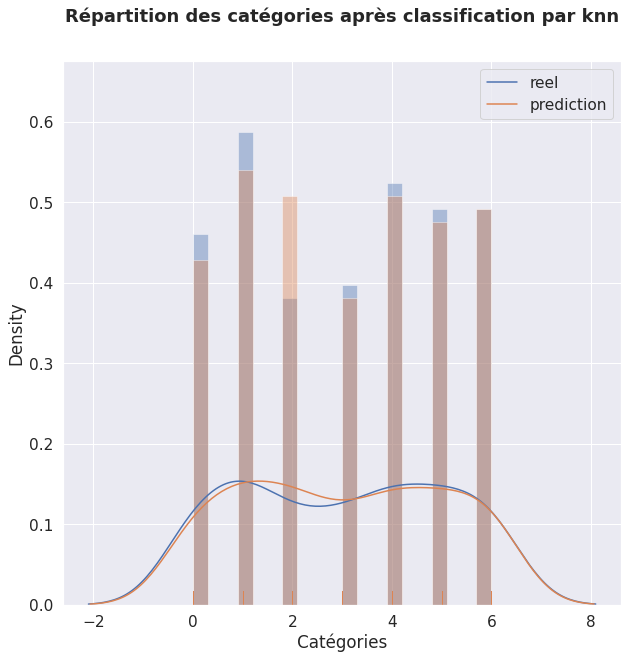

In [111]:
plt.figure(figsize=(10, 10))
plt.title('Répartition des catégories après classification par knn',
          fontsize=18, fontweight="bold")
sns.distplot(rf_class['label_cat_reel'], bins=20, rug=True)
sns.distplot(rf_class['label_cat_predit'], bins=20, rug=True)
plt.xlabel("Catégories")
plt.legend(['reel', 'prediction'])

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les catégories 0, 1, 3, 4 et 5, la classification par random forest regroupe moins de produits dans ces catégories par rapport à la réalité. La conclusion inverse peut être faîte pour la catégorie 2 (computers). Pour la catégorie 6 la classification par rf regroupe autant de produits dans cette catégorie par rapport à la réalité.

0 = baby_care
1 = beauty_and_personal_care
2 = computers
3 = home_decor_and_festive_needs
4 = home_furnishing
5 = kitchen_and_dining
6 = watches


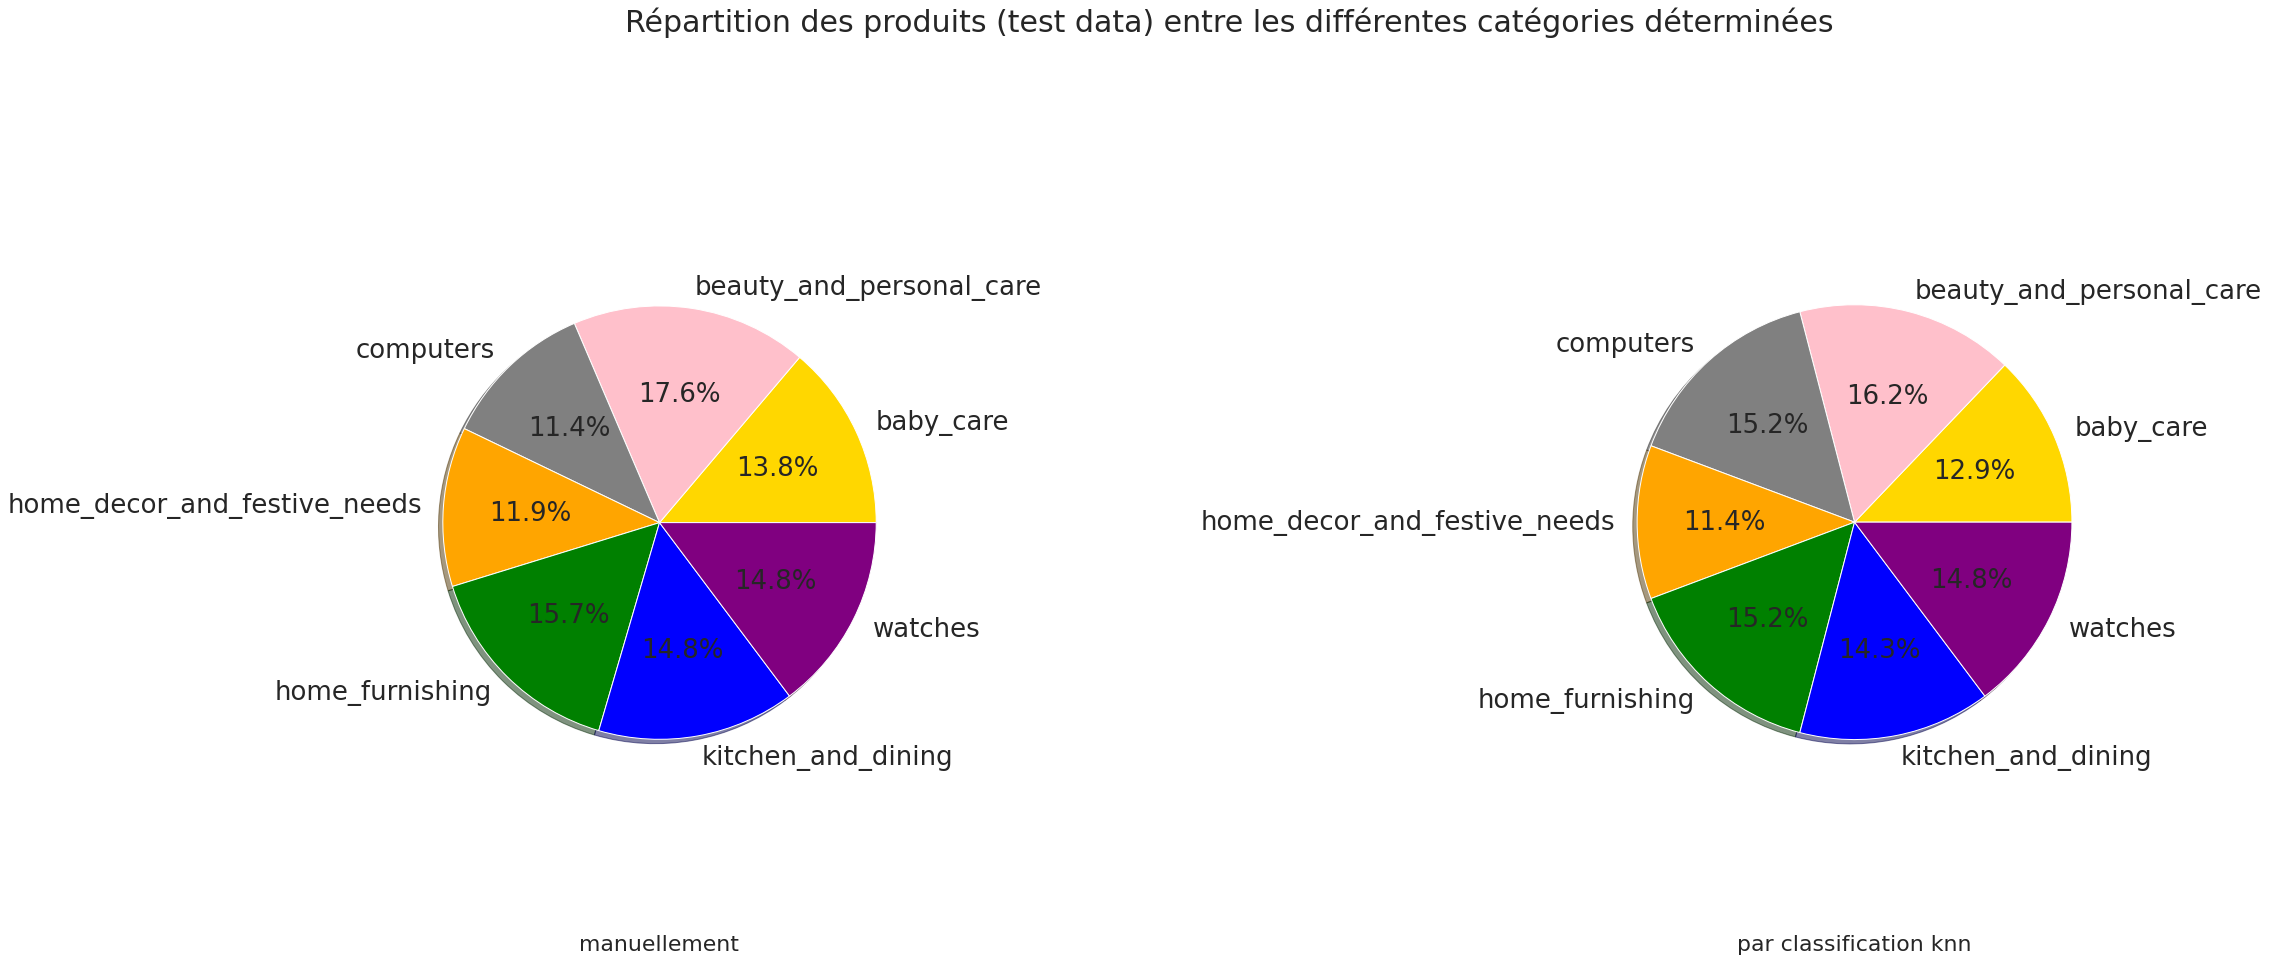

In [112]:
fig = plt.figure(figsize=(30, 15))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


ax1 = rf_class.groupby('cat_reel').count().plot(kind='pie',
                                                y='label_cat_reel',
                                                ax=ax1,
                                                legend=False,
                                                shadow=True,
                                                startangle=0,
                                                autopct='%1.1f%%',
                                                textprops={'fontsize': 26},
                                                colors=['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple'])
ax1.axis('equal')
ax1.set_xlabel("manuellement", fontsize=22)
ax1.set_ylabel(" ")


ax2 = rf_class.groupby('cat_predit').count().plot(kind='pie',
                                                  y='label_cat_predit',
                                                  ax=ax2,
                                                  legend=False,
                                                  shadow=True,
                                                  startangle=0,
                                                  autopct='%1.1f%%',
                                                  textprops={'fontsize': 26},
                                                  colors=['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple'])
ax2.axis('equal')
ax2.set_xlabel("par classification knn", fontsize=22)
ax2.set_ylabel(" ")

plt.suptitle('Répartition des produits (test data) entre les différentes catégories déterminées',
             fontsize=30)

plt.subplots_adjust(wspace=1.5)

plt.show()

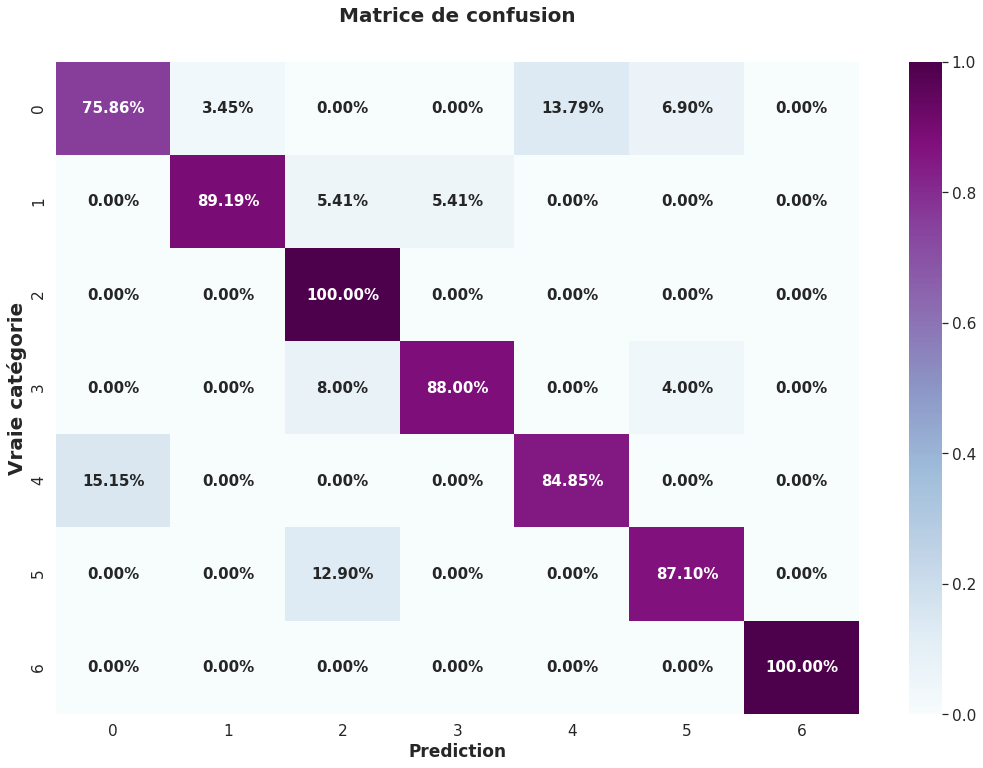

In [113]:
cf_matrix = confusion_matrix(
    rf_class["cat_reel"], rf_class["cat_predit"], normalize='true')
plt.figure(figsize=(18, 12))
plt.title('Matrice de confusion', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cf_matrix, annot=True,  # cf_matrix/np.sum(cf_matrix)=normalize=all
            fmt='.2%', cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'})
plt.ylabel("Vraie catégorie", weight='bold', size=20)
plt.xlabel('Prediction', weight='bold', size=17)
plt.show()

L'algorithme a plus de mal à prédire les catégories 0, 1, 3 et 4 mais de façon très faible.

## <font color='blue'>Combinaison des probabilités image + description</font>

In [114]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/

open_file = open("proba_prediction_description_rf.pkl", "rb")
proba_prediction_description_rf = pickle.load(open_file)
open_file.close()
print(proba_prediction_description_rf)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
[[0.13805146 0.08550216 0.1079672  ... 0.1478921  0.23085482 0.07272216]
 [0.78053681 0.02231004 0.03478301 ... 0.04577792 0.04795249 0.04526197]
 [0.76607365 0.05070383 0.0409077  ... 0.04790938 0.0358146  0.02281099]
 ...
 [0.03475622 0.0667356  0.63594559 ... 0.04407327 0.09137707 0.02090573]
 [0.03366995 0.04376181 0.81479528 ... 0.0269687  0.03160507 0.02217263]
 [0.03366995 0.04376181 0.81479528 ... 0.0269687  0.03160507 0.02217263]]


In [115]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/

open_file = open("proba_prediction_image_cnn.pkl", "rb")
proba_prediction_image_cnn = pickle.load(open_file)
open_file.close()
print(proba_prediction_image_cnn)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
[[3.5158644e-16 1.9895142e-12 5.6425917e-36 ... 9.3360141e-14
  4.1952361e-20 9.9999988e-01]
 [1.0000000e+00 4.4294621e-21 3.5592798e-22 ... 1.5600742e-10
  2.3367349e-08 4.1835616e-13]
 [1.2955138e-04 5.3446595e-08 3.6717810e-07 ... 4.3401320e-12
  3.1956148e-19 6.8199378e-04]
 ...
 [1.1065733e-08 3.2137439e-07 9.8907872e-13 ... 4.5997162e-08
  4.5584309e-12 9.9999964e-01]
 [6.8256165e-25 2.3635848e-14 9.3629671e-07 ... 2.2708388e-34
  7.7163473e-16 9.9999905e-01]
 [2.1465370e-10 5.6039959e-01 4.3959931e-01 ... 1.0048411e-06
  1.1771001e-11 5.8575228e-08]]


In [116]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/

test_real_cat = pd.read_csv('/content/drive/MyDrive/y_test_nt3.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [117]:
dico_categ = {0: 'baby_care',
              1: 'beauty_and_personal_care',
              2: 'computers',
              3: 'home_decor_and_festive_needs',
              4: 'home_furnishing',
              5: 'kitchen_and_dining',
              6: 'watches'}

In [118]:
"""proba_prediction_description_rf = proba_prediction_rf
proba_prediction_image_cnn = proba_prediction_cnn
test_real_cat = y_test"""

'proba_prediction_description_rf = proba_prediction_rf\nproba_prediction_image_cnn = proba_prediction_cnn\ntest_real_cat = y_test'

In [119]:
alpha_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

print(colored('Les probabilités de classification de chaque image sont données par', 'red'))
print(colored('l\'association d\'une prédiction des descriptions et des images sous la forme :', 'red'))
print(colored('prob_combinée = alpha * proba_prediction_description + (1-alpha) * proba_prediction_image\n \n ', 'red'))

for x in range(0, 11, 1):
    alpha = x/10
    alpha_list.append(alpha)
    print(colored("Test pour alpha : {}".format(alpha), 'blue'))

    prob_total = alpha * proba_prediction_description_rf + \
        (1-alpha) * proba_prediction_image_cnn  # fine-tune alpha with validation set
    y_classes = [np.argmax(element) for element in prob_total]
    combine_cat_predict = pd.DataFrame(y_classes, columns=['predict_category'])
    df_combine_cat_predict = combine_cat_predict.replace(
        {"predict_category": dico_categ})
    resume_cnn = pd.concat([df_combine_cat_predict, test_real_cat], axis=1)

    print(colored("\n Qualité de la classification ", 'magenta'))
    accuracy = accuracy_score(
        resume_cnn['category'], resume_cnn['predict_category'])
    print('L\'accuracy score est de', colored(
        '{:.3f}'.format(accuracy), 'green'))
    accuracy_list.append(accuracy)

    precision = precision_score(
        resume_cnn['category'], resume_cnn['predict_category'], average='weighted')
    print('La score précision est de', colored(
        '{:.3f}'.format(precision), 'green'))
    precision_list.append(precision)

    recall = recall_score(
        resume_cnn['category'], resume_cnn['predict_category'], average='weighted')
    print('Le score recall est de', colored('{:.3f}'.format(recall), 'green'))
    recall_list.append(recall)

    f1 = f1_score(resume_cnn['category'],
                  resume_cnn['predict_category'], average='weighted')
    print('Le score f1 est de', colored('{:.3f}'.format(f1), 'green'))
    f1_list.append(f1)

    print(colored("\n Visualisation ", 'magenta'))
    le = preprocessing.LabelEncoder()
    resume_cnn['label_cat_reel'] = le.fit_transform(
        np.array(resume_cnn['category']))
    resume_cnn['label_cat_predit'] = le.transform(
        np.array(resume_cnn['predict_category']))

    plt.figure(figsize=(10, 10))
    plt.title('Répartition des catégories après classification\n \n ',
              fontsize=18, fontweight="bold")
    sns.distplot(resume_cnn['label_cat_reel'], bins=20, rug=True)
    sns.distplot(resume_cnn['label_cat_predit'], bins=20, rug=True)
    plt.xlabel("Catégories")
    plt.legend(['reel', 'prediction'])
    plt.show()

    print("\n")
    fig = plt.figure(figsize=(30, 15))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    nb_label_real = resume_cnn['category'].nunique()
    cs_nb_label_real = cm.Set1(np.arange(nb_label_real))
    nb_label_predit = resume_cnn['predict_category'].nunique()
    cs_nb_label_predit = cm.Set1(np.arange(nb_label_predit))

    ax1 = resume_cnn.groupby('category').count().plot(kind='pie',
                                                      y='label_cat_reel',
                                                      ax=ax1,
                                                      legend=False,
                                                      shadow=True,
                                                      startangle=0,
                                                      autopct='%1.1f%%',
                                                      textprops={
                                                          'fontsize': 26},
                                                      colors=cs_nb_label_real)
    ax1.axis('equal')
    ax1.set_xlabel("classes réelles", fontsize=22)
    ax1.set_ylabel(" ")

    ax2 = resume_cnn.groupby('predict_category').count().plot(kind='pie',
                                                              y='label_cat_predit',
                                                              ax=ax2,
                                                              legend=False,
                                                              shadow=True,
                                                              startangle=0,
                                                              autopct='%1.1f%%',
                                                              textprops={
                                                                  'fontsize': 26},
                                                              colors=cs_nb_label_predit)
    ax2.axis('equal')
    ax2.set_xlabel(
        "classes prédites par l'association description et image", fontsize=22)
    ax2.set_ylabel(" ")

    plt.suptitle('Répartition des produits (test data) entre les différentes catégories déterminées',
                 fontsize=30)

    plt.subplots_adjust(wspace=1.5)

    plt.show()

    print("\n")
    cf_matrix = confusion_matrix(
        resume_cnn["category"], resume_cnn["predict_category"], normalize='true')
    plt.figure(figsize=(18, 12))
    plt.title('Matrice de confusion', size=20, weight='bold')
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cf_matrix, annot=True,
                fmt='.2%', cmap='BuPu',
                annot_kws={"size": 15, 'weight': 'bold'})
    plt.ylabel("Vraie catégorie", weight='bold', size=20)
    plt.xlabel('Prediction', weight='bold', size=17)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [120]:
alpha_score = pd.DataFrame({'alpha': alpha_list, 'accuracy': accuracy_list,
                           'precision': precision_list, 'recall': recall_list, 'f1': f1_list})
alpha_score

,alpha,accuracy,precision,recall,f1
0,0.0,0.585714,0.640518,0.585714,0.569462
1,0.1,0.585714,0.640518,0.585714,0.569462
2,0.2,0.590476,0.645834,0.590476,0.576969
3,0.3,0.590476,0.646928,0.590476,0.578638
4,0.4,0.590476,0.646928,0.590476,0.578638
5,0.5,0.600000,0.661605,0.600000,0.590777
6,0.6,0.728571,0.759444,0.728571,0.728072
7,0.7,0.804762,0.817831,0.804762,0.803555
8,0.8,0.833333,0.840936,0.833333,0.833257
9,0.9,0.876190,0.877869,0.876190,0.875281


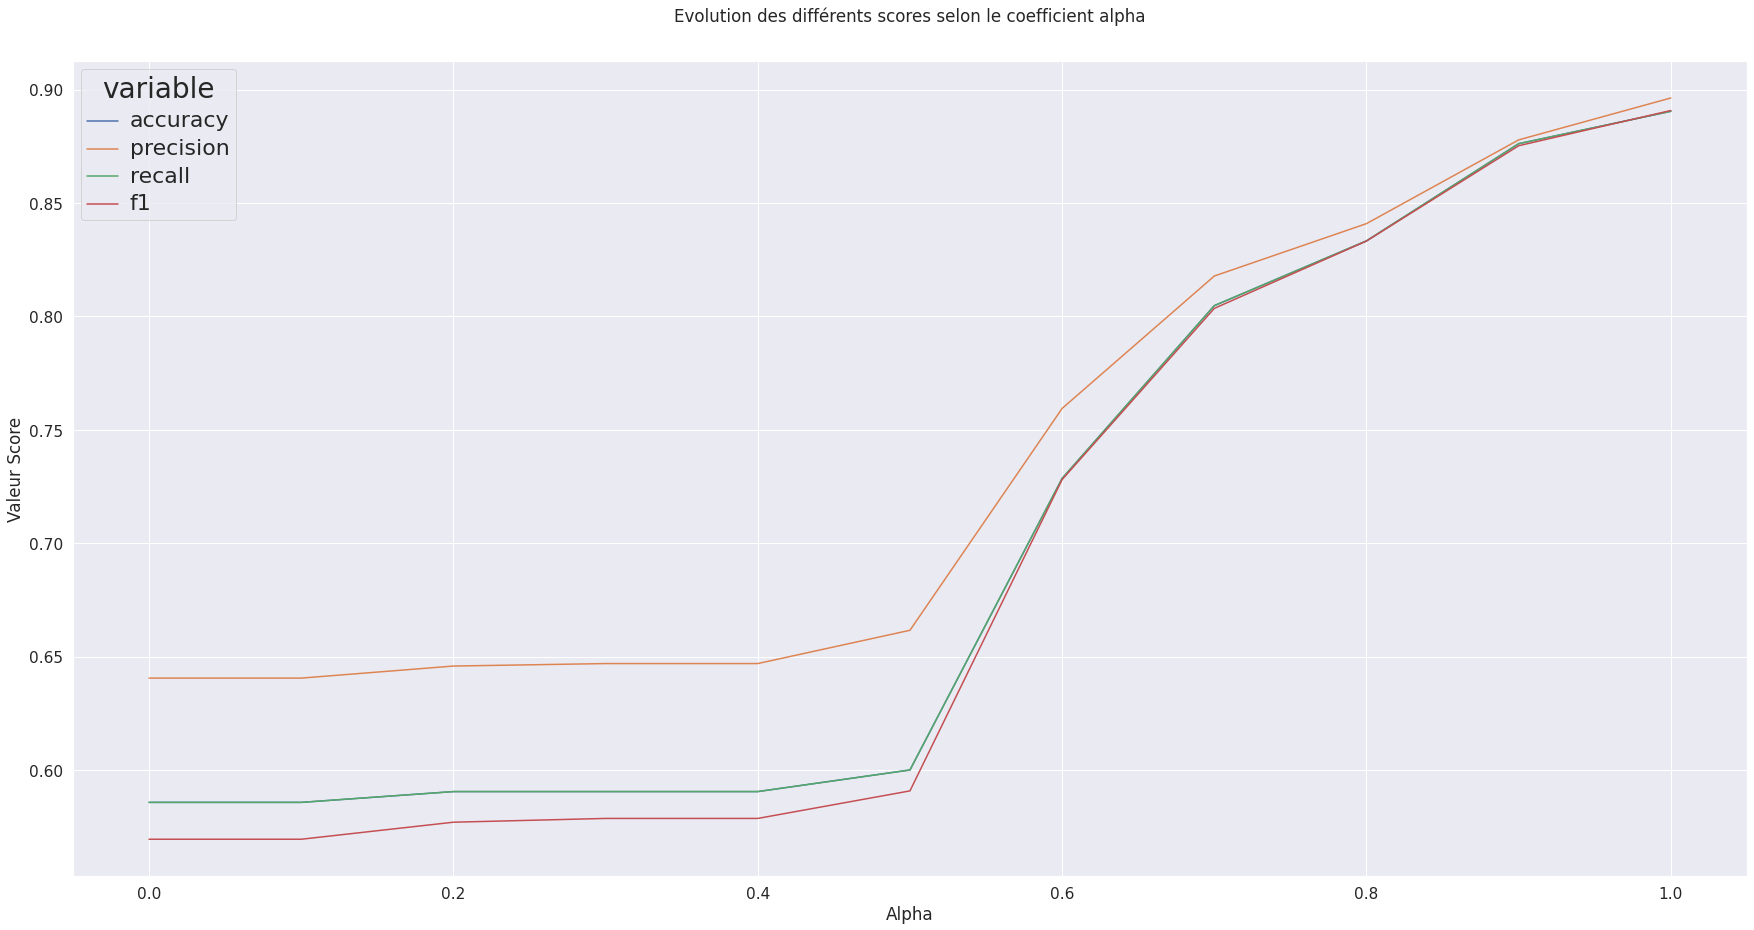

In [121]:
plt.figure(figsize=(30, 15))


ax = sns.lineplot(x='alpha', y='value', hue='variable',
                  data=pd.melt(alpha_score, ['alpha']))
ax.set_title('Evolution des différents scores selon le coefficient alpha')
ax.set_ylabel('Valeur Score')
ax.set_xlabel('Alpha')
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='28')

plt.show()

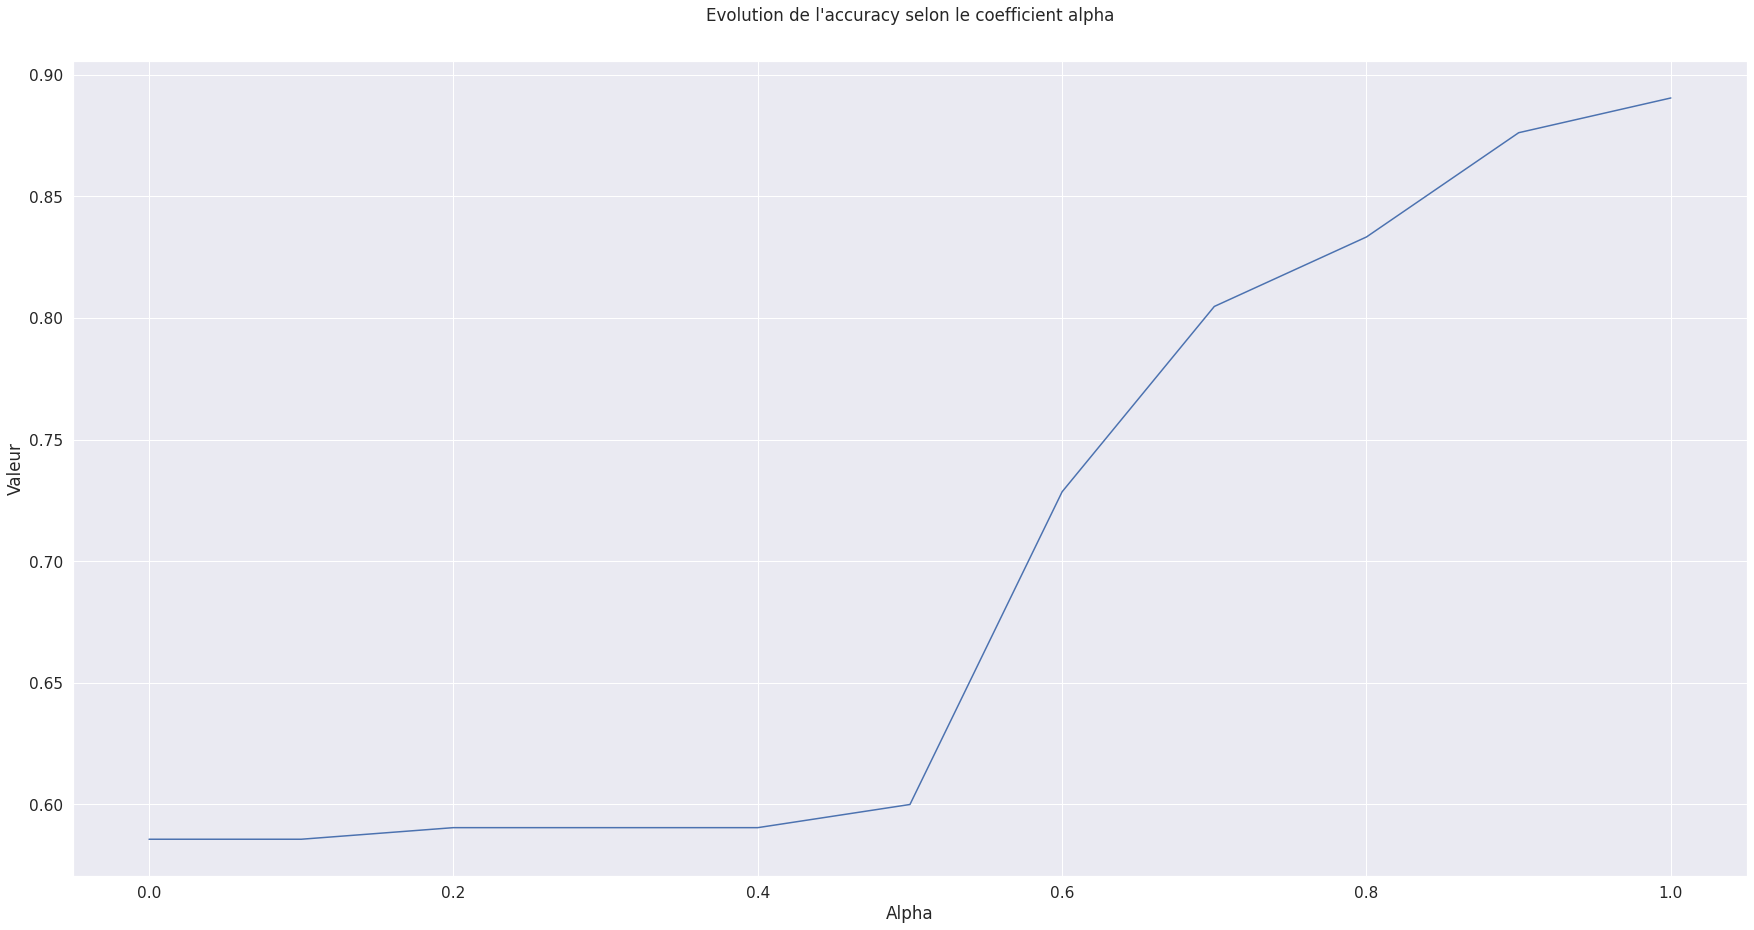

In [122]:
plt.figure(figsize=(30, 15))

ax = sns.lineplot(data=alpha_score, x="alpha", y="accuracy")
ax.set_title('Evolution de l\'accuracy selon le coefficient alpha')
ax.set_ylabel('Valeur')
ax.set_xlabel('Alpha')

plt.show()

Lorsque que l’on regarde l’évolution de l’accuracy en fonction du coeffcient alpha, on remarque qur pour alpha = 0, on retrouve bien l’accuracy du CNN des images seules. De même, pour alpha = 1, on retrouve bien l’accuracy du random forest des desciptions seules. On peut voir au niveau de alpha = 0,9 un pic nous montrant le coefficient alpha optimal à appliquer. 

La classification des produits à partir de leur description a 89% de bonnes prédictions avec une précision de 89%.

La classification des produits à partir de leur image a 60% de bonnes prédictions avec une précision de 65%.

La classification des produits à partir de la combinaison description + image atteint 88% de bonnes prédictions. Ce score est atteint lorsque l'on donne un coefficient de 0,9 pour la prédiction des produits à partir des descriptions et 0,1 pour la prédiction des produits à partir des images. Il faut donc faire plus confiance à la prédiction proposée par les descriptions qui est plus fiable et il est plus facile de catégoriser des produits à partir de leur description plutôt qu'à partir d'une image.

# <font color='green'>Conclusion</font>

Le Clustering permet bien de rassembler les articles entre eux (grâce à l'association description et image) mais les résultats et l'exactitude de celui-ci est trop peu précis.

La Classification quant a elle donne de meilleurs résultats car plus de 85% des produits se voient attribuer la bonne catégorie.


Il faut faire plus confiance à la prédiction proposée par les descriptions qui est plus fiable et il est plus facile de catégoriser des produits à partir de leur description plutôt qu'à partir d'une image.




Les recommandations :

Photos d'une certaine qualité

Enrichir base de données

Avoir une approche combinée NLP + CV
